In [546]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import category_encoders as ce
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 0)

In [547]:
plt.style.use('seaborn-v0_8')
sns.set_theme(style='ticks', palette='pastel')

In [548]:
# Reading the dataset file
df = pd.read_csv('Data.csv')

In [549]:
# checking the dimension of the dataset
df.shape

(99999, 27)

In [550]:
# having a glance of the dataset
df.head()

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour,y
0,False,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,962c8333,be6db1d7,1,0,22683,320,50,2528,0,39,100075,221,10,1,28,14,0
1,True,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,5b1f94b9,1b13b020,1,0,17037,320,50,1934,2,39,-1,16,10,2,22,19,1
2,False,1005,0,e3c09f3a,d262cf1e,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,a9a84f4c,9a45a8e8,1,0,22155,320,50,2552,3,167,100202,23,10,3,23,18,0
3,False,1002,0,0da94452,248e439f,50e219e0,ecad2386,7801e8d9,07d7df22,0fa578fd,88c62dad,ea6abc60,0,0,21591,320,50,2478,3,167,100074,23,10,2,22,19,0
4,True,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,1e5e0d0e,36d749e5,1,0,15708,320,50,1722,0,35,-1,79,10,1,21,8,1


# Data Preparation

### Checking for null values in the dataset

In [551]:
# checking for null values in the dataset and dtype of each columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   click             99999 non-null  bool  
 1   C1                99999 non-null  int64 
 2   banner_pos        99999 non-null  int64 
 3   site_id           99999 non-null  object
 4   site_domain       99999 non-null  object
 5   site_category     99999 non-null  object
 6   app_id            99999 non-null  object
 7   app_domain        99999 non-null  object
 8   app_category      99999 non-null  object
 9   device_id         99999 non-null  object
 10  device_ip         99999 non-null  object
 11  device_model      99999 non-null  object
 12  device_type       99999 non-null  int64 
 13  device_conn_type  99999 non-null  int64 
 14  C14               99999 non-null  int64 
 15  C15               99999 non-null  int64 
 16  C16               99999 non-null  int64 
 17  C17         

In [552]:
# checking for null values in the dataset
df.isnull().sum()

click               0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
month               0
dayofweek           0
day                 0
hour                0
y                   0
dtype: int64

No null value found in the dataset and identified categorical columns

### Checking for outliers

In [553]:
# checking for 
df.describe(percentiles = [.8, .9, .95, .98, .99])

,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour,y
count,99999.000000,99999.000000,99999.00000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.0,99999.000000,99999.000000,99999.000000,99999.000000
mean,1004.967550,0.289943,1.01639,0.329453,18857.231732,318.834548,60.278743,2114.613036,1.439904,227.234932,53292.001950,83.163542,10.0,2.592836,25.485755,11.300673,0.169802
std,1.091916,0.505707,0.53110,0.854673,4944.919482,21.510752,47.713436,607.469442,1.326824,351.472366,49952.340367,70.161076,0.0,1.723003,2.968520,5.938725,0.375460
min,1001.000000,0.000000,0.00000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,1.000000,10.0,0.000000,21.000000,0.000000,0.000000
50%,1005.000000,0.000000,1.00000,0.000000,20346.000000,320.000000,50.000000,2323.000000,2.000000,39.000000,100050.000000,61.000000,10.0,2.000000,26.000000,11.000000,0.000000
80%,1005.000000,1.000000,1.00000,0.000000,22288.000000,320.000000,50.000000,2545.000000,3.000000,297.000000,100112.000000,157.000000,10.0,4.000000,29.000000,17.000000,0.000000
90%,1005.000000,1.000000,1.00000,2.000000,23144.000000,320.000000,50.000000,2665.000000,3.000000,803.000000,100173.000000,221.000000,10.0,5.000000,30.000000,19.000000,1.000000
95%,1005.000000,1.000000,1.00000,3.000000,23561.000000,320.000000,90.000000,2691.000000,3.000000,1063.000000,100191.000000,221.000000,10.0,6.000000,30.000000,21.000000,1.000000
98%,1010.000000,1.000000,4.00000,3.000000,23804.000000,320.000000,250.000000,2726.000000,3.000000,1327.000000,100194.000000,221.000000,10.0,6.000000,30.000000,23.000000,1.000000
99%,1010.000000,1.000000,4.00000,3.000000,23866.000000,320.000000,250.000000,2736.000000,3.000000,1327.000000,100210.000000,229.000000,10.0,6.000000,30.000000,23.000000,1.000000


Columns C15, C16, C19, and C21 have outliers, so we can cap their value to .98 percentile

In [554]:
# Capping columns C15, C16, C19 and C21 oto .98 percentile as it have outliers
cols = ['C15', 'C16', 'C19', 'C21']
for col in cols:
    if df[col].quantile(.98) < .5*df[col].max():
        df[col][df[col] > df[col].quantile(.98)] = df[col].quantile(.98)
        print(col)

C15
C16


This updated the columns C15 and C16 values to cap it max .98 percentile values

Checking again outliers for numeric columns

In [555]:
df[[col for col in df.columns if df[col].dtype != 'object']].describe(percentiles=[.8,.85,.9,.95,.98])

,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour,y
count,99999.000000,99999.000000,99999.00000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.0,99999.000000,99999.000000,99999.000000,99999.000000
mean,1004.967550,0.289943,1.01639,0.329453,18857.231732,317.998540,59.598856,2114.613036,1.439904,227.234932,53292.001950,83.163542,10.0,2.592836,25.485755,11.300673,0.169802
std,1.091916,0.505707,0.53110,0.854673,4944.919482,10.364193,42.891568,607.469442,1.326824,351.472366,49952.340367,70.161076,0.0,1.723003,2.968520,5.938725,0.375460
min,1001.000000,0.000000,0.00000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,1.000000,10.0,0.000000,21.000000,0.000000,0.000000
50%,1005.000000,0.000000,1.00000,0.000000,20346.000000,320.000000,50.000000,2323.000000,2.000000,39.000000,100050.000000,61.000000,10.0,2.000000,26.000000,11.000000,0.000000
80%,1005.000000,1.000000,1.00000,0.000000,22288.000000,320.000000,50.000000,2545.000000,3.000000,297.000000,100112.000000,157.000000,10.0,4.000000,29.000000,17.000000,0.000000
85%,1005.000000,1.000000,1.00000,0.000000,22683.000000,320.000000,50.000000,2616.000000,3.000000,547.000000,100148.000000,212.000000,10.0,5.000000,29.000000,18.000000,1.000000
90%,1005.000000,1.000000,1.00000,2.000000,23144.000000,320.000000,50.000000,2665.000000,3.000000,803.000000,100173.000000,221.000000,10.0,5.000000,30.000000,19.000000,1.000000
95%,1005.000000,1.000000,1.00000,3.000000,23561.000000,320.000000,90.000000,2691.000000,3.000000,1063.000000,100191.000000,221.000000,10.0,6.000000,30.000000,21.000000,1.000000
98%,1010.000000,1.000000,4.00000,3.000000,23804.000000,320.000000,250.000000,2726.000000,3.000000,1327.000000,100194.000000,221.000000,10.0,6.000000,30.000000,23.000000,1.000000


There no outliers now in the dataframe

In [556]:
# Treating categorical columns and numerical columns separately
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
categorical_cols

['site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_domain',
 'app_category',
 'device_id',
 'device_ip',
 'device_model']

In [557]:
numerical_cols = [col for col in df.columns if df[col].dtype != 'object']
numerical_cols

['click',
 'C1',
 'banner_pos',
 'device_type',
 'device_conn_type',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21',
 'month',
 'dayofweek',
 'day',
 'hour',
 'y']

In [558]:
# checking the distibution of class
df['y'].value_counts(normalize=True)

0    0.830198
1    0.169802
Name: y, dtype: float64

Dataset is highly imbalanced with 83% of False results and only 17% of True results

<AxesSubplot: >

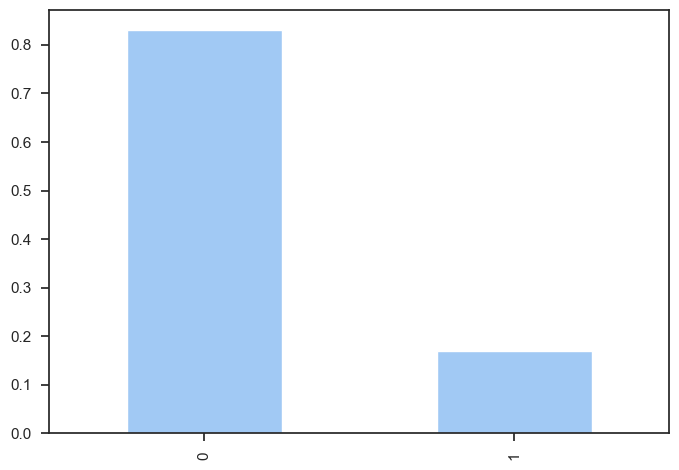

In [559]:
# Plotting the value counts for visualization of imbalance in data
df['y'].value_counts(normalize=True).plot.bar()


Columns y and click are same, we can drop one of them. Here we will be going to drop columns 'click'

### Analysing Categorical Columns

In [560]:
for col in categorical_cols:
    print(col)
    print(f'number of unique values in column {col} is {len(df[col].unique())}')
    print(df[col].value_counts(normalize=True), '\n\n')

site_id
number of unique values in column site_id is 1485
85f751fd    0.360224
1fbe01fe    0.158622
e151e245    0.065971
d9750ee7    0.023760
5b08c53b    0.023050
              ...   
9e1b18be    0.000010
27e10723    0.000010
1661bb7f    0.000010
1edf0277    0.000010
bf991633    0.000010
Name: site_id, Length: 1485, dtype: float64 


site_domain
number of unique values in column site_domain is 1331
c4e18dd6    0.373624
f3845767    0.158622
7e091613    0.082801
7687a86e    0.032200
98572c79    0.024560
              ...   
babf5d87    0.000010
a63817ea    0.000010
8d450543    0.000010
66cf2855    0.000010
bde22369    0.000010
Name: site_domain, Length: 1331, dtype: float64 


site_category
number of unique values in column site_category is 19
50e219e0    0.408394
f028772b    0.314083
28905ebd    0.181072
3e814130    0.076681
f66779e6    0.006340
75fa27f6    0.003920
335d28a8    0.003580
76b2941d    0.002470
c0dd3be3    0.001040
72722551    0.000640
dedf689d    0.000580
70fb0e29    0.000

##### Observations:
- we have to encode the categorical columns.
- we can't use one-hot encoding as there are a lot of unique values for categorical variable which will create a lot of new features
- we can't use label encoder as the values assgined by label encoder will be used by model and it will get unintended ordinality of the feature.

- we'll use target encoder as it is best for high-cardinality dataset.

We'll perform encoding after splitting the data into training and test set to avoid any data leakage during fitting the encoder and model.

### Analysing Numerical Columns

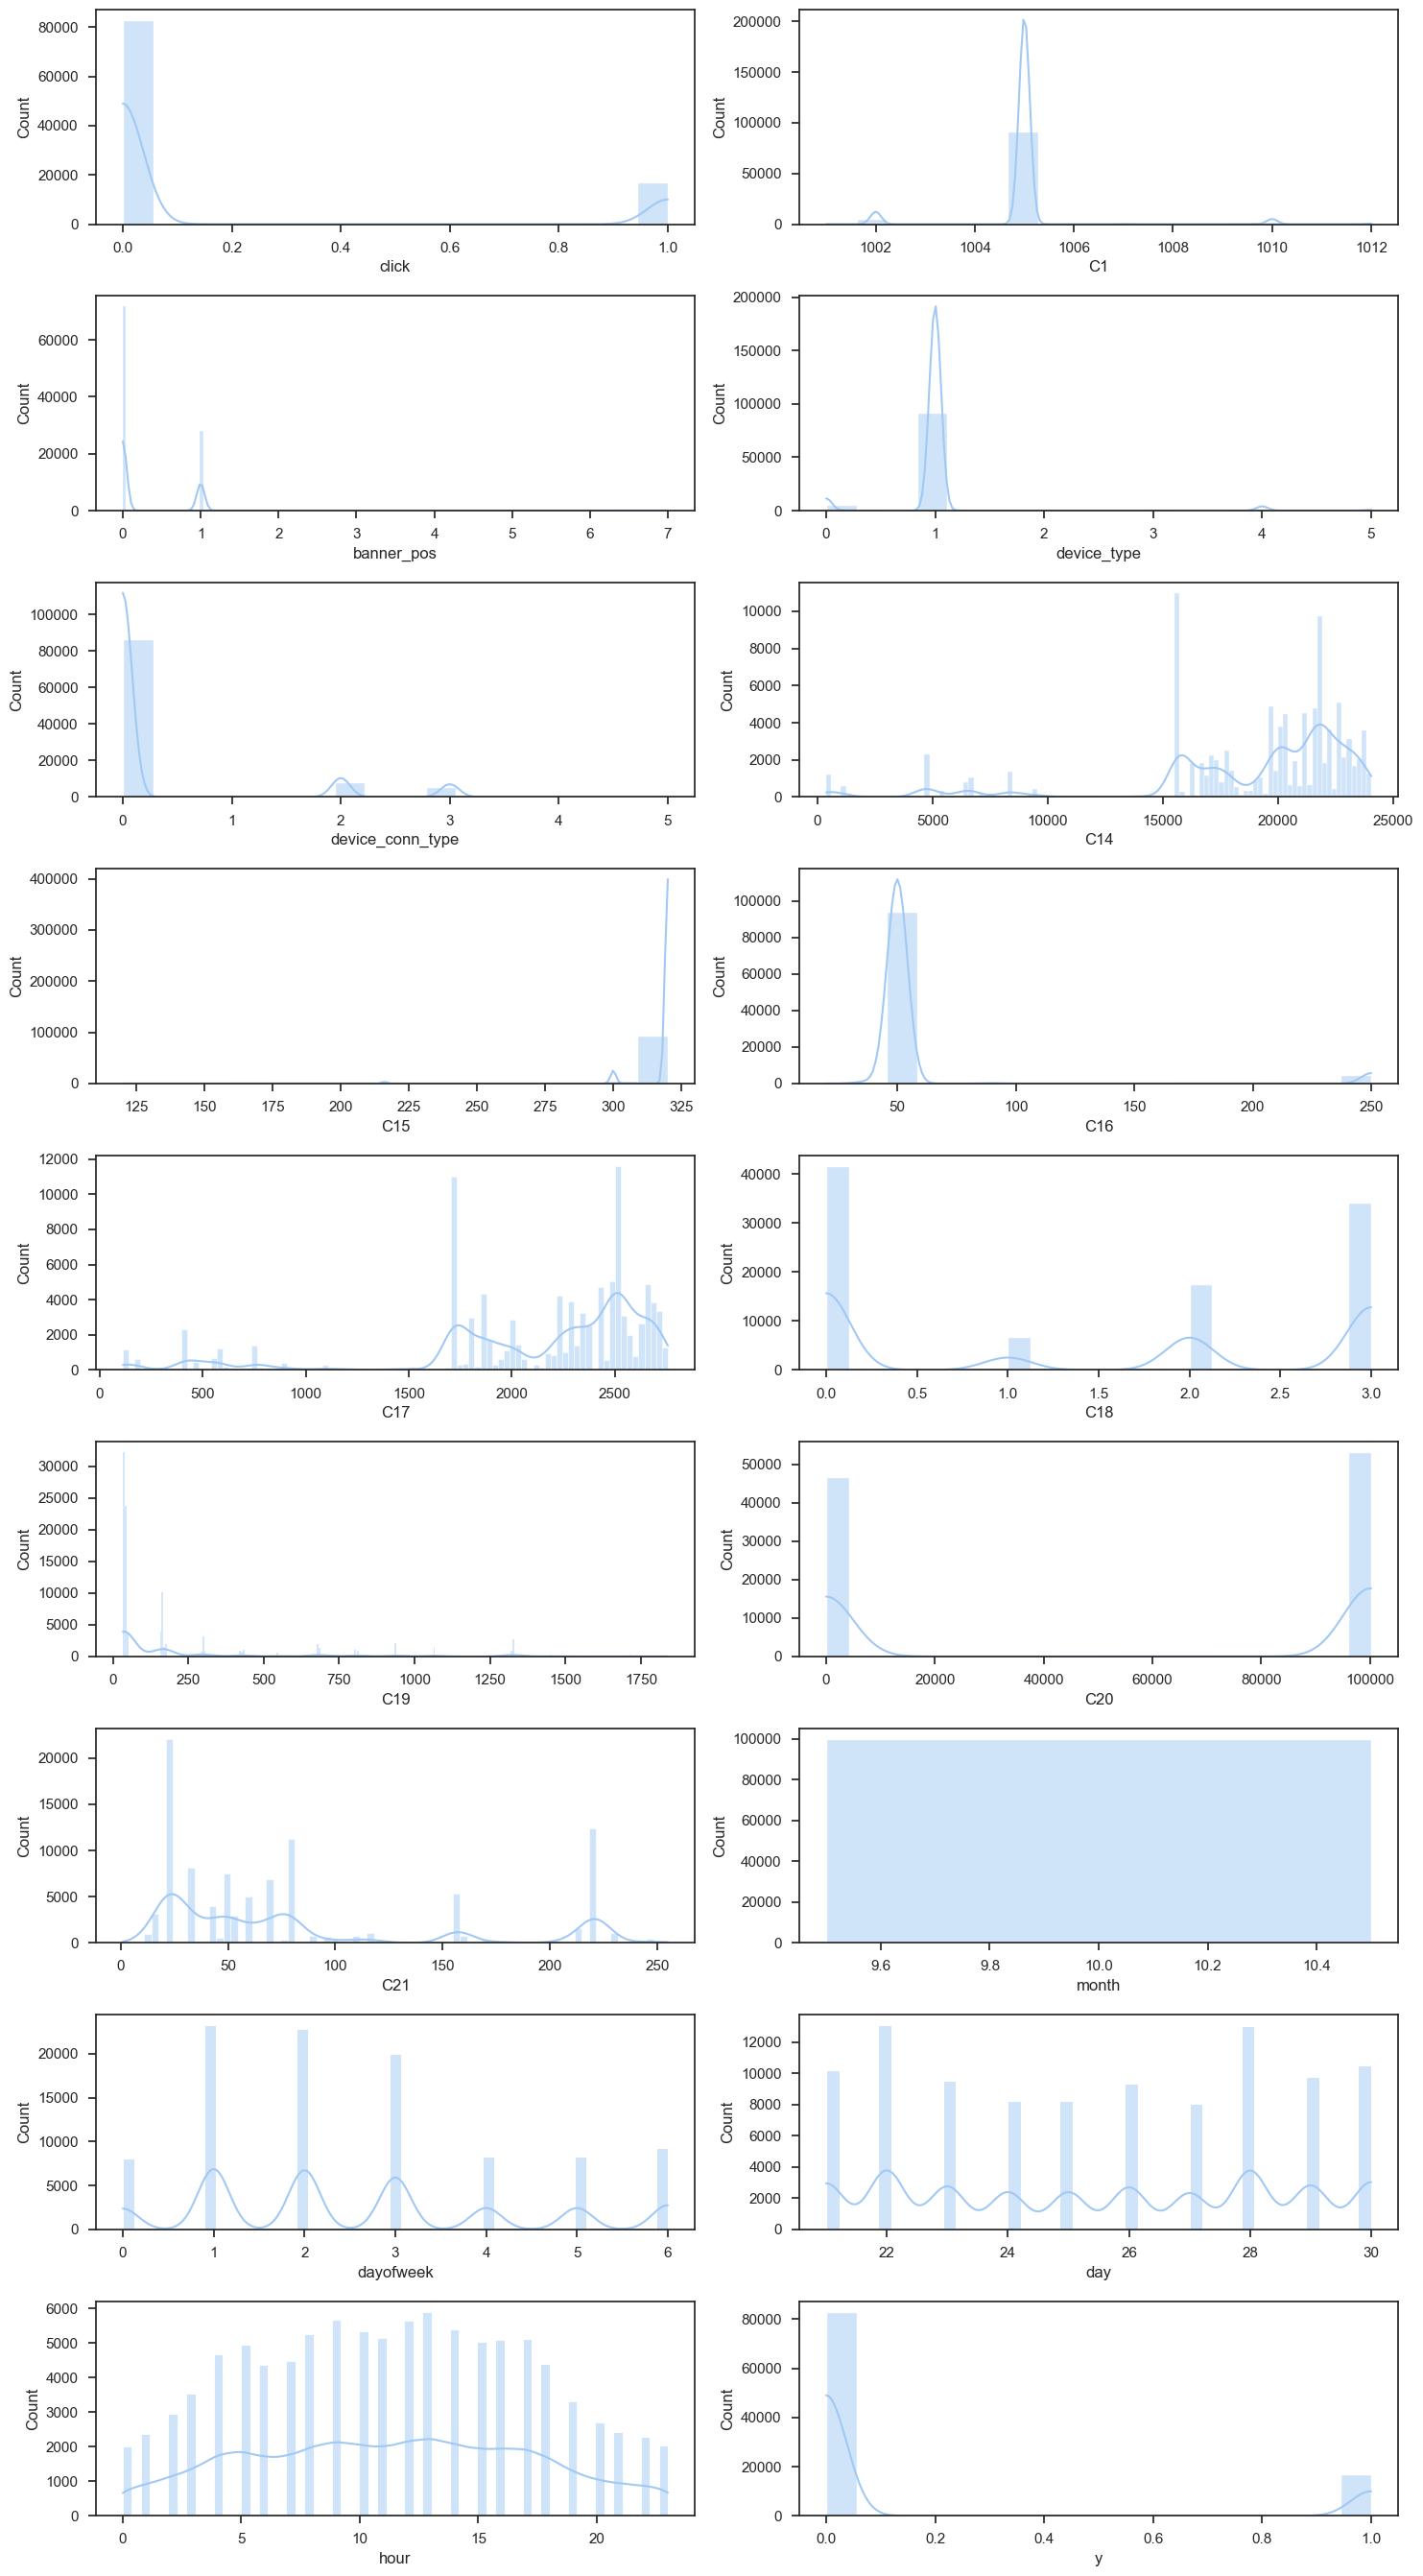

In [561]:
# plotting histograms for all numerical columns 

n = 2
plt.figure(figsize=[15,27])

for i in range(len(numerical_cols)):
    plt.subplot(9 ,n,i+1)
    sns.histplot(df[numerical_cols[i]], kde=True)

plt.tight_layout()
plt.show()

Observations:
- Month have only one value, so we can drop it
- y and click are same and are target variable, we can drop click and use y
- 47% of values in columns C20 are -1 and as categorical variable it should not have -1. So dropping it

#### Visualizing correlation matrix to identify correlation between features

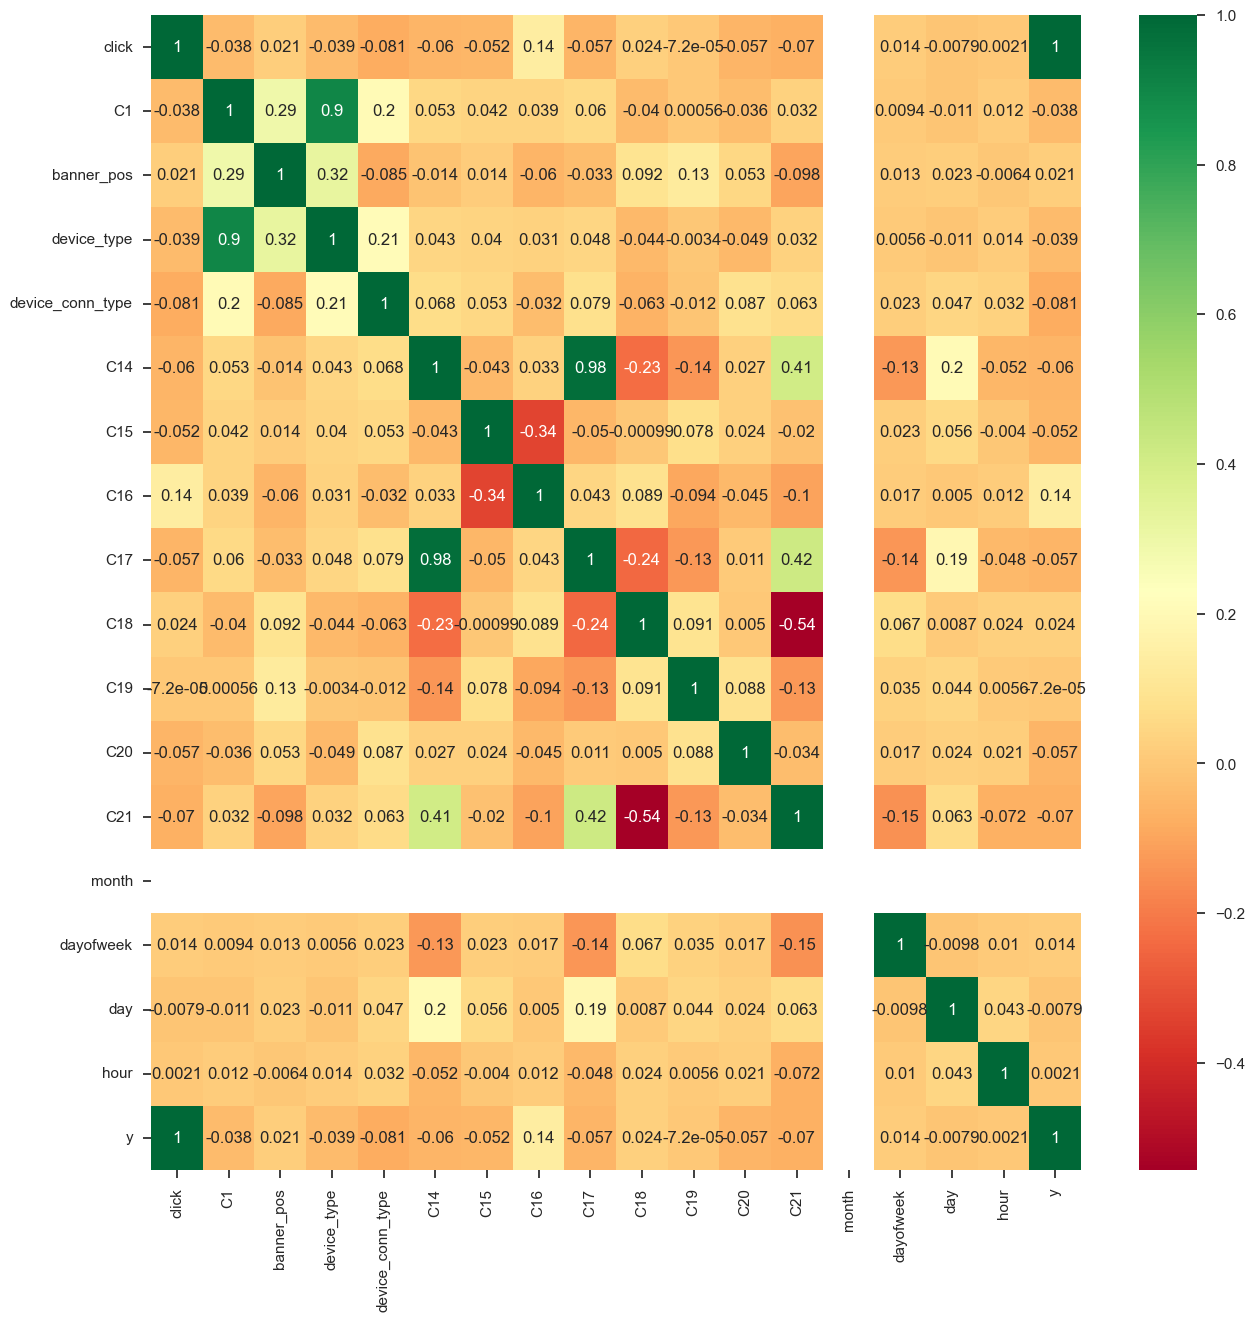

In [562]:
plt.figure(figsize=[15,15])
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
plt.show()

##### Observations:
- columns C1 and device_type are highly correlated, we can drop either of them. Dropping C1 as it is anonamized data.
- coumns C14 and C17 are highly correlated, we can drop either of them. Dropping C14 for our case.

## Data Cleaning

#### Dropping columns

In [563]:
# dropping columns month and C20 no
df.drop(['C1', 'C14', 'month', 'C20', 'click'], axis=1, inplace= True)

In [564]:
# Taking a peek at the data after dropping columns
df.head()

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour,y
0,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,962c8333,be6db1d7,1,0,320,50,2528,0,39,221,1,28,14,0
1,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,5b1f94b9,1b13b020,1,0,320,50,1934,2,39,16,2,22,19,1
2,0,e3c09f3a,d262cf1e,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,a9a84f4c,9a45a8e8,1,0,320,50,2552,3,167,23,3,23,18,0
3,0,0da94452,248e439f,50e219e0,ecad2386,7801e8d9,07d7df22,0fa578fd,88c62dad,ea6abc60,0,0,320,50,2478,3,167,23,2,22,19,0
4,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,1e5e0d0e,36d749e5,1,0,320,50,1722,0,35,79,1,21,8,1


Splitting data into X and Y before performing any data cleaning or oversampling

In [565]:
Y = df['y']
X = df.drop('y', axis=1)

#### Getting Dummies

Creating dummies for columns banner_pos, day, dayofweek, hour and dropping the first one and then adding the result to master dataframe

In [566]:
device_type = pd.get_dummies(X['device_type'], prefix='device_type', drop_first=True)
X = pd.concat([X, device_type], axis=1)
banner_pos = pd.get_dummies(X['banner_pos'], prefix='banner_pos', drop_first=True)
X = pd.concat([X, banner_pos], axis=1)
day = pd.get_dummies(X['day'], prefix='day', drop_first=True)
X = pd.concat([X, day], axis=1)
dayofweek = pd.get_dummies(X['dayofweek'], prefix='dayofweek', drop_first=True)
X = pd.concat([X, dayofweek], axis=1)
hour = pd.get_dummies(X['hour'], prefix='hour', drop_first=True)
X = pd.concat([X, hour], axis=1)

In [567]:
# Dropping the encoded columns
X.drop(['banner_pos', 'day', 'dayofweek', 'hour', 'device_type'], axis=1, inplace=True)

In [568]:
# looking at data after the change
X.head()

,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_conn_type,C15,C16,C17,C18,C19,C21,device_type_1,device_type_4,device_type_5,banner_pos_1,banner_pos_2,banner_pos_3,banner_pos_4,banner_pos_5,banner_pos_7,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,962c8333,be6db1d7,0,320,50,2528,0,39,221,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,5b1f94b9,1b13b020,0,320,50,1934,2,39,16,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,e3c09f3a,d262cf1e,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,a9a84f4c,9a45a8e8,0,320,50,2552,3,167,23,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0da94452,248e439f,50e219e0,ecad2386,7801e8d9,07d7df22,0fa578fd,88c62dad,ea6abc60,0,320,50,2478,3,167,23,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,1e5e0d0e,36d749e5,0,320,50,1722,0,35,79,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Classification Model Building

We'll be using three classification machine learning models, Logistic Regression, Decision Tree and Random Forest.
With the above mentioned models, we'll try to further refine the models using feature selection or gridseachcv for hyperparameter tuning.

- Metrics used:
    - Accuracy: for evaluating the overall accuracy of the model for both training and test dataset both see if the model is overfitting.
    - Recall: for evaluatin the accuracy of positive prediction. 
    - Precision: for evaluating the number of correctly predicted positive outcomes out of all positive predictions.
    - Precision and recall will be our preferred metrics to evaluate the model on as for this case we want the to predict the minority class correctly.
    - roc_auc_score: for evaluating the model's performance on distinguishing between negative and positive outcomes
    

## Splitting data into training and test dataset

Now data is ready for machine learning model implementation.

We can split the data into training and test dataset

In [569]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, stratify=Y, test_size=0.3, random_state=42)

In [570]:
# Looking at the training data
xtrain.head()

,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_conn_type,C15,C16,C17,C18,C19,C21,device_type_1,device_type_4,device_type_5,banner_pos_1,banner_pos_2,banner_pos_3,banner_pos_4,banner_pos_5,banner_pos_7,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
53023,222acd54,de0f0f82,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,7bab62b3,be6db1d7,0,320,50,1882,3,35,13,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16863,5b08c53b,7687a86e,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,81e4946e,1f0bc64f,0,300,250,1994,2,39,33,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
88091,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,f7afd93a,fce66524,0,320,50,2647,2,35,23,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
75881,85f751fd,c4e18dd6,50e219e0,89bdfe24,2347f47a,0f2161f8,a99f214a,877c72d4,0e010a30,0,300,250,2331,2,39,23,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
61015,93de26ae,7d05db75,335d28a8,ecad2386,7801e8d9,07d7df22,a99f214a,01b6a40d,b7c5bc1f,0,320,50,2506,0,35,157,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Target encoding the training and test data

In [571]:
te = ce.TargetEncoder()
encoding_col = ['site_category', 'site_domain', 'site_id', 'device_conn_type', 'device_id', 'device_ip', 'device_model', 'app_category', 'app_domain', 'app_id']
xtrain[encoding_col] = te.fit_transform(xtrain[encoding_col], ytrain)
xtest[encoding_col] = te.transform(xtest[encoding_col])

In [572]:
# looking at the training data after target encoding
xtrain.head()

,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_conn_type,C15,C16,C17,C18,C19,C21,device_type_1,device_type_4,device_type_5,banner_pos_1,banner_pos_2,banner_pos_3,banner_pos_4,banner_pos_5,banner_pos_7,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
53023,0.045470,0.055173,0.177497,0.197156,0.193841,0.198344,0.172913,0.143574,0.177706,0,320,50,1882,3,35,13,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16863,0.459046,0.463489,0.285582,0.197156,0.193841,0.198344,0.172913,0.277818,0.219725,0,300,250,1994,2,39,33,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
88091,0.293670,0.255573,0.177497,0.197156,0.193841,0.198344,0.172913,0.147710,0.292379,0,320,50,2647,2,35,23,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
75881,0.120950,0.125537,0.131141,0.277233,0.143048,0.104972,0.172913,0.209901,0.287567,0,300,250,2331,2,39,23,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
61015,0.121764,0.121764,0.080000,0.197156,0.193841,0.198344,0.172913,0.147710,0.196400,0,320,50,2506,0,35,157,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [573]:
# looking at the test data after target encoding
xtest.head()

,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_conn_type,C15,C16,C17,C18,C19,C21,device_type_1,device_type_4,device_type_5,banner_pos_1,banner_pos_2,banner_pos_3,banner_pos_4,banner_pos_5,banner_pos_7,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
94821,0.120950,0.125537,0.131141,0.043716,0.193841,0.104972,0.169802,0.169802,0.102400,3,320,50,1895,0,681,101,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
50031,0.120950,0.125537,0.131141,0.061281,0.081370,0.104972,0.172913,0.169802,0.038338,0,320,50,2548,3,937,61,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
43776,0.248945,0.248945,0.177497,0.197156,0.193841,0.198344,0.172913,0.147710,0.136790,0,320,50,1800,3,167,23,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
60357,0.242291,0.242291,0.177497,0.197156,0.193841,0.198344,0.172913,0.169802,0.136790,0,320,50,1800,3,167,23,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
91629,0.120950,0.125537,0.131141,0.061281,0.081370,0.104972,0.172913,0.169802,0.053263,0,320,50,1092,3,811,61,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


checking dimensions of the training and test datasets

In [574]:
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(69999, 63)
(30000, 63)
(69999,)
(30000,)


In [575]:
xtrain.head()

,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_conn_type,C15,C16,C17,C18,C19,C21,device_type_1,device_type_4,device_type_5,banner_pos_1,banner_pos_2,banner_pos_3,banner_pos_4,banner_pos_5,banner_pos_7,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
53023,0.045470,0.055173,0.177497,0.197156,0.193841,0.198344,0.172913,0.143574,0.177706,0,320,50,1882,3,35,13,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16863,0.459046,0.463489,0.285582,0.197156,0.193841,0.198344,0.172913,0.277818,0.219725,0,300,250,1994,2,39,33,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
88091,0.293670,0.255573,0.177497,0.197156,0.193841,0.198344,0.172913,0.147710,0.292379,0,320,50,2647,2,35,23,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
75881,0.120950,0.125537,0.131141,0.277233,0.143048,0.104972,0.172913,0.209901,0.287567,0,300,250,2331,2,39,23,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
61015,0.121764,0.121764,0.080000,0.197156,0.193841,0.198344,0.172913,0.147710,0.196400,0,320,50,2506,0,35,157,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Feature Standardisation

In [576]:
cols = ['C15', 'C16', 'C17', 'C18', 'C19', 'C21']
x_temp = xtrain[cols]

In [577]:
normalized_xtemp = (x_temp-x_temp.mean())/x_temp.std()
xtrain = xtrain.drop(cols, axis=1)
xtrain = pd.concat([xtrain, normalized_xtemp], axis=1)
xtrain.head()

,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_conn_type,device_type_1,device_type_4,device_type_5,banner_pos_1,banner_pos_2,banner_pos_3,banner_pos_4,banner_pos_5,banner_pos_7,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,C15,C16,C17,C18,C19,C21
53023,0.045470,0.055173,0.177497,0.197156,0.193841,0.198344,0.172913,0.143574,0.177706,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.192637,-0.223234,-0.383420,1.174823,-0.546007,-0.998958
16863,0.459046,0.463489,0.285582,0.197156,0.193841,0.198344,0.172913,0.277818,0.219725,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.739334,4.450581,-0.198959,0.421501,-0.534611,-0.713519
88091,0.293670,0.255573,0.177497,0.197156,0.193841,0.198344,0.172913,0.147710,0.292379,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.192637,-0.223234,0.876516,0.421501,-0.546007,-0.856239
75881,0.120950,0.125537,0.131141,0.277233,0.143048,0.104972,0.172913,0.209901,0.287567,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.739334,4.450581,0.356072,0.421501,-0.534611,-0.856239
61015,0.121764,0.121764,0.080000,0.197156,0.193841,0.198344,0.172913,0.147710,0.196400,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.192637,-0.223234,0.644292,-1.085144,-0.546007,1.056201


In [578]:
x_temp1 = xtest[['C15', 'C16', 'C17', 'C18', 'C19', 'C21']]

In [579]:
normalized_xtemp = (x_temp1-x_temp1.mean())/x_temp1.std()
xtest = xtest.drop(['C15', 'C16', 'C17', 'C18', 'C19', 'C21'], axis=1)
xtest = pd.concat([xtest, normalized_xtemp], axis=1)
xtest.head()

,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_conn_type,device_type_1,device_type_4,device_type_5,banner_pos_1,banner_pos_2,banner_pos_3,banner_pos_4,banner_pos_5,banner_pos_7,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,C15,C16,C17,C18,C19,C21
94821,0.120950,0.125537,0.131141,0.043716,0.193841,0.104972,0.169802,0.169802,0.102400,3,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.194218,-0.225091,-0.360378,-1.085404,1.283022,0.247834
50031,0.120950,0.125537,0.131141,0.061281,0.081370,0.104972,0.172913,0.169802,0.038338,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.194218,-0.225091,0.713337,1.178107,2.009069,-0.320523
43776,0.248945,0.248945,0.177497,0.197156,0.193841,0.198344,0.172913,0.147710,0.136790,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.194218,-0.225091,-0.516585,1.178107,-0.174745,-0.860461
60357,0.242291,0.242291,0.177497,0.197156,0.193841,0.198344,0.172913,0.169802,0.136790,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.194218,-0.225091,-0.516585,1.178107,-0.174745,-0.860461
91629,0.120950,0.125537,0.131141,0.061281,0.081370,0.104972,0.172913,0.169802,0.053263,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.194218,-0.225091,-1.680735,1.178107,1.651718,-0.320523


In [580]:
# checking the class imbalance in training dataset
ytrain.value_counts(normalize=True)

0    0.830198
1    0.169802
Name: y, dtype: float64

value counts of 1's and 0's in the training data is same as the master dataset

In [581]:
ytest.value_counts(normalize=True)

0    0.8302
1    0.1698
Name: y, dtype: float64

value counts of 1's and 0's in test data as well is same as the master dataset.

## Creating functions to store evaluation metrics, draw roc curve

In [582]:
from sklearn.model_selection import cross_val_score

In [583]:
# this function will store the results in dataframe for each ML model used

def results(model_name, xtrain, xtest, ytrain, ytest, model, n_folds):
    
    crossvalidation = cross_val_score(model, xtrain, ytrain, cv= n_folds)
    ypred = model.predict(xtest)
    test_accuracy = metrics.accuracy_score(ytest, ypred)
    test_recall = metrics.recall_score(ytest, ypred)
    test_precision = metrics.precision_score(ytest, ypred)


    ypred_train = model.predict(xtrain)
    train_accuracy = metrics.accuracy_score(ytrain, ypred_train)
    train_recall = metrics.recall_score(ytrain, ypred_train)
    train_precision = metrics.precision_score(ytrain, ypred_train)
    f1_score = metrics.f1_score(ytest, ypred)
    roc_auc_score = metrics.roc_auc_score(ytest, ypred)

    entry = {'Model': [model_name],
          'Accuracy_train': [train_accuracy],
          'recall_train': [train_recall],
          'precision_train': [train_precision],
          'Accuracy_test': [test_accuracy],
          'recall_test': [test_recall],
          'precision_test': [test_precision],
          'f1_score_test': [f1_score],
          'CrossVal_Mean': [crossvalidation.mean()],           
          'CrossVal1': [crossvalidation[0]],
          'CrossVal2': [crossvalidation[1]],
          'CrossVal3': [crossvalidation[2]],
          'CrossVal4': [crossvalidation[3]],
          'CrossVal5': [crossvalidation[4]],
          }
    result = pd.DataFrame(entry)
    return result

In [584]:
## Creating function to draw roc curve and returning fpr, tpr, and threshold
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

## Dummy Classifier comparing future models

In [585]:
from sklearn.dummy import DummyClassifier

In [586]:
# Instantiating the Dummy Classifier
dummy_clf = DummyClassifier(strategy='most_frequent')

In [587]:
# fitting the modelt to training dataset
dummy_clf.fit(xtrain, ytrain)

DummyClassifier(strategy='most_frequent')

accuracy of dummy classifier: 0.8302


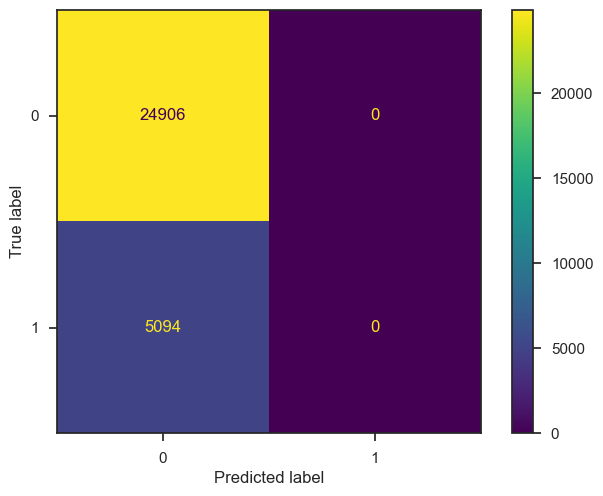

In [588]:
ypred = dummy_clf.predict(xtest)        # predicting the outcome for test dataset
accuracy = metrics.accuracy_score(ytest, ypred)     # measuring test accuracy of the model
cnf_mat = metrics.confusion_matrix(ytest, ypred)    # generating confusion matrix for the model
print('accuracy of dummy classifier:', accuracy)
metrics.ConfusionMatrixDisplay.from_predictions(ytest, ypred)   # To visualize confusion matrix

Dummy classifier with predicting the most frequent class have accuracy of 83%

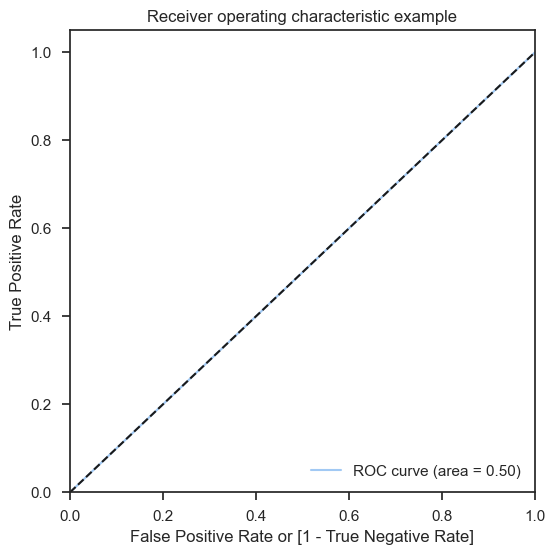

(array([0., 1.]), array([0., 1.]), array([1, 0], dtype=int64))

In [589]:
# Drawing roc curve for dummy classifier
draw_roc(ytest, ypred)

Adding metrics of dummy classifier into the results dataframe

In [590]:
metrics_results = pd.DataFrame()

In [591]:
metrics_results = pd.concat([metrics_results, results('Dummy Classifier', xtrain, xtest, ytrain, ytest, dummy_clf, 5)], axis=0)
metrics_results

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,f1_score_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy Classifier,0.830198,0.0,0.0,0.8302,0.0,0.0,0.0,0.830198,0.830214,0.830214,0.830214,0.830143,0.830202


## Logistic Regression Basic model

In [592]:
# Instantiating basic logisitic regression model
logreg_basic = LogisticRegression(random_state=42)

accuracy of the basic logistic regression model:  0.81


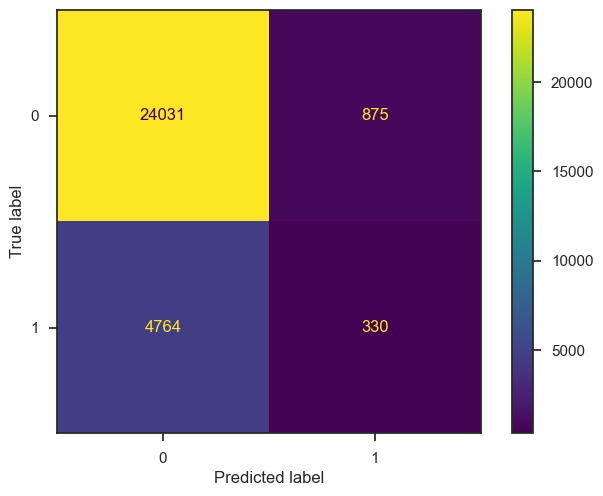

In [593]:
logreg_basic.fit(xtrain, ytrain)    # fitting the basic logistic regression model
ypred = logreg_basic.predict(xtest)     # making prediction for test dataset
print('accuracy of the basic logistic regression model: ', round(metrics.accuracy_score(ytest, ypred), 2))  # calculating test accuracy for basic logreg model
metrics.ConfusionMatrixDisplay.from_predictions(ytest, ypred)       # visualizing the confusion matrix for this model

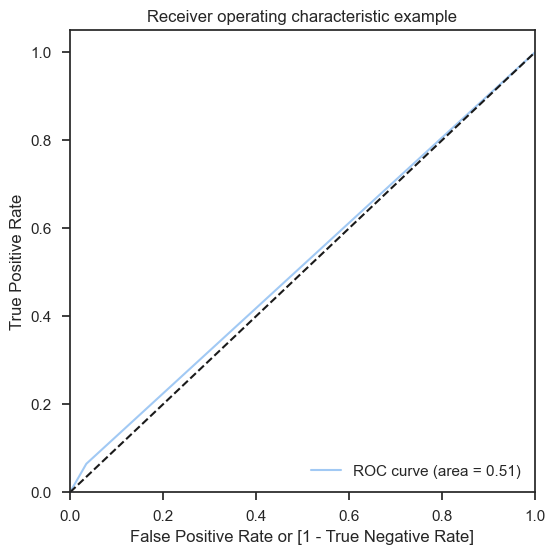

'0.51'

In [594]:
# Drawing roc curve and calculating roc_auc score for basic logistic regression model
draw_roc(ytest, ypred)
'{:2.2f}'.format(metrics.roc_auc_score(ytest, ypred))

In [595]:
print(metrics.classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89     24906
           1       0.27      0.06      0.10      5094

    accuracy                           0.81     30000
   macro avg       0.55      0.51      0.50     30000
weighted avg       0.74      0.81      0.76     30000



Accuracy for logistic regression is better than dummy classifier. However, roc_auc_score is very less, that means its not able to distinguish between negative and positive outcomes

Adding metrics of Logistic Regression model to metrics results dataframe

In [596]:
metrics_results = pd.concat([metrics_results, results('Basic Logistic Regression', xtrain, xtest, ytrain, ytest, logreg_basic, 5)], axis=0)
metrics_results

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,f1_score_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy Classifier,0.830198,0.000000,0.000000,0.830200,0.000000,0.000000,0.000000,0.830198,0.830214,0.830214,0.830214,0.830143,0.830202
0,Basic Logistic Regression,0.957414,0.836446,0.905547,0.812033,0.064782,0.273859,0.104779,0.957528,0.956357,0.958571,0.955357,0.959286,0.958068


From the list of all metrics, we can see that the basic logistic regression model have overfitted the data and performing well with training data. However, with test dataset the accuracy seems okay, but precision and recall values are very less compared to the training score

We can try to oversample data to improve the results

## Logistic Regression with balanced class

We can use oversampling of the dataset to overcome the imbalance of classes.
Using SMOTE for oversampling the data

In [597]:
# importing the oversampling library
from imblearn.over_sampling import SMOTE

In [598]:
# instantiating SMOTE
smote = SMOTE(random_state=42)

In [599]:
# Slitting the data again as the traing and test data were encoded and scaled before
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=.3, random_state=42, stratify=Y)

target encoding the training and test dataset

In [600]:
# fitting the target encoder to training set and transforming training and test dataset
xtrain[encoding_col] = te.fit_transform(xtrain[encoding_col], ytrain)
xtest[encoding_col] = te.transform(xtest[encoding_col])

Fitting and oversampling the training dataset

In [601]:
xtrain_res, ytrain_res = smote.fit_resample(xtrain, ytrain)
xtest_res, ytest_res = smote.fit_resample(xtest, ytest)

Scaling the training and test dataset using standard scaler

In [602]:
# scaling the training and test dataset using standard scaler
scaler = StandardScaler()
xtrain_res = scaler.fit_transform(xtrain_res)
xtest_res = scaler.transform(xtest_res)

In [603]:
# instantiating the logisitic regression model
logreg = LogisticRegression(n_jobs=-1, random_state=42)

In [604]:
logreg.fit(xtrain_res, ytrain_res)      # fitting the logreg model to oversampled training dataset

ypred_smote = logreg.predict(xtest_res)     # predicting from logreg model
metrics.accuracy_score(ytest_res, ypred_smote)  # measuring accuracy of the logreg model on oversampled test data

0.7420099574399743

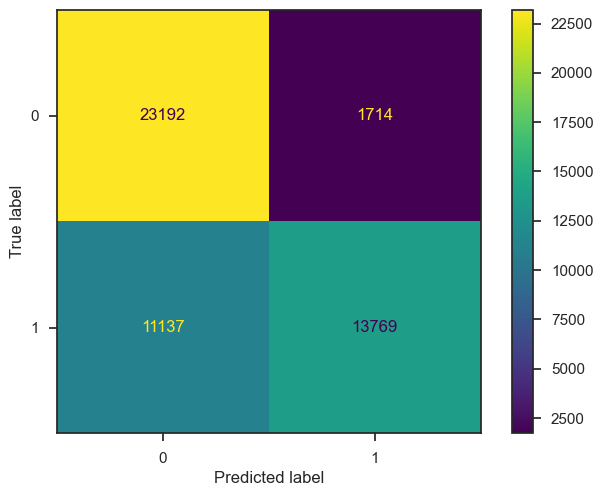

In [605]:
metrics.ConfusionMatrixDisplay.from_predictions(ytest_res, ypred_smote)   # visualizing confusion matrix

In [606]:
# checking the roc_auc score for current model
metrics.roc_auc_score(ytest_res, ypred_smote)

0.7420099574399742

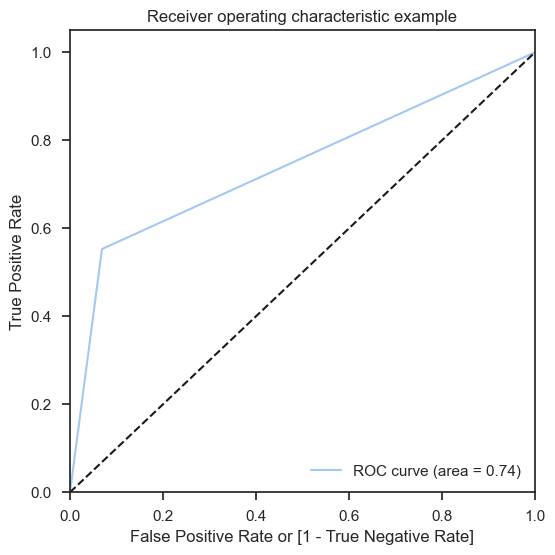

(array([0.        , 0.06881876, 1.        ]),
 array([0.        , 0.55283867, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [607]:
# plotting the roc curve for logistic regression model fited on oversampled data
draw_roc(ytest_res, ypred_smote)

In [608]:
# checking all other metrics
print(metrics.classification_report(ytest_res, ypred_smote))

              precision    recall  f1-score   support

           0       0.68      0.93      0.78     24906
           1       0.89      0.55      0.68     24906

    accuracy                           0.74     49812
   macro avg       0.78      0.74      0.73     49812
weighted avg       0.78      0.74      0.73     49812



Adding metrics from logistic regression fitted on overampled data to metrics_results dataframe

In [609]:
metrics_results = pd.concat([metrics_results, results('Logistic Regression with oversampling', xtrain_res, xtest_res, ytrain_res, ytest_res, logreg, 5)], axis=0)
metrics_results

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,f1_score_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy Classifier,0.830198,0.000000,0.000000,0.830200,0.000000,0.000000,0.000000,0.830198,0.830214,0.830214,0.830214,0.830143,0.830202
0,Basic Logistic Regression,0.957414,0.836446,0.905547,0.812033,0.064782,0.273859,0.104779,0.957528,0.956357,0.958571,0.955357,0.959286,0.958068
0,Logistic Regression with oversampling,0.956920,0.956326,0.957463,0.742010,0.552839,0.889298,0.681819,0.955277,0.924761,0.962702,0.962314,0.963820,0.962788


With oversampling, test accuracy have not increased. However, the precision and recall for the test dataset have increased.

It's evident that oversampling helps in the model efficiency, we'll further tune the model with feature engineering. For now let's look at the Decision Tree Model

## Decision Tree Classifier

For decision tree classifier, we won't have to do encoding or get dummies for anonamised categorical data
However, we still need to do target encoding to categorical features

In [610]:
from sklearn.tree import DecisionTreeClassifier

Creating new X and Y as we don't have to perform get dummies or standardise the data for tree models

In [611]:
Y_new = df['y']
X_new = df.drop('y', axis=1)

In [612]:
X_new.head()

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
0,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,962c8333,be6db1d7,1,0,320,50,2528,0,39,221,1,28,14
1,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,5b1f94b9,1b13b020,1,0,320,50,1934,2,39,16,2,22,19
2,0,e3c09f3a,d262cf1e,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,a9a84f4c,9a45a8e8,1,0,320,50,2552,3,167,23,3,23,18
3,0,0da94452,248e439f,50e219e0,ecad2386,7801e8d9,07d7df22,0fa578fd,88c62dad,ea6abc60,0,0,320,50,2478,3,167,23,2,22,19
4,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,1e5e0d0e,36d749e5,1,0,320,50,1722,0,35,79,1,21,8


### Building a basic decision tree classifier with maximum depth of 10

In [613]:
# instantiating the decision tree classifier with max_depth as 10
dtree = DecisionTreeClassifier(max_depth=10)

In [614]:
# Splitting the data into trainign and test data set`

xtrain1, xtest1, ytrain1, ytest1 = train_test_split(X_new, Y_new, test_size=.3, stratify=Y, random_state=42)

In [615]:
# target encoding the categorical columns assigned

xtrain1[encoding_col] = te.fit_transform(xtrain1[encoding_col], ytrain1)
xtest1[encoding_col] = te.transform(xtest1[encoding_col])

In [616]:
xtrain1.head()

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
53023,1,0.045470,0.055173,0.177497,0.197156,0.193841,0.198344,0.172913,0.143574,0.177706,1,0,320,50,1882,3,35,13,6,26,5
16863,0,0.459046,0.463489,0.285582,0.197156,0.193841,0.198344,0.172913,0.277818,0.219725,1,0,300,250,1994,2,39,33,1,28,3
88091,1,0.293670,0.255573,0.177497,0.197156,0.193841,0.198344,0.172913,0.147710,0.292379,1,0,320,50,2647,2,35,23,1,28,18
75881,0,0.120950,0.125537,0.131141,0.277233,0.143048,0.104972,0.172913,0.209901,0.287567,1,0,300,250,2331,2,39,23,3,23,6
61015,1,0.121764,0.121764,0.080000,0.197156,0.193841,0.198344,0.172913,0.147710,0.196400,1,0,320,50,2506,0,35,157,2,22,12


In [617]:
xtest1.head()

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
94821,1,0.120950,0.125537,0.131141,0.043716,0.193841,0.104972,0.169802,0.169802,0.102400,4,3,320,50,1895,0,681,101,4,24,22
50031,0,0.120950,0.125537,0.131141,0.061281,0.081370,0.104972,0.172913,0.169802,0.038338,1,0,320,50,2548,3,937,61,3,23,22
43776,1,0.248945,0.248945,0.177497,0.197156,0.193841,0.198344,0.172913,0.147710,0.136790,1,0,320,50,1800,3,167,23,5,25,18
60357,1,0.242291,0.242291,0.177497,0.197156,0.193841,0.198344,0.172913,0.169802,0.136790,1,0,320,50,1800,3,167,23,4,24,10
91629,0,0.120950,0.125537,0.131141,0.061281,0.081370,0.104972,0.172913,0.169802,0.053263,1,0,320,50,1092,3,811,61,2,29,17


0.8044


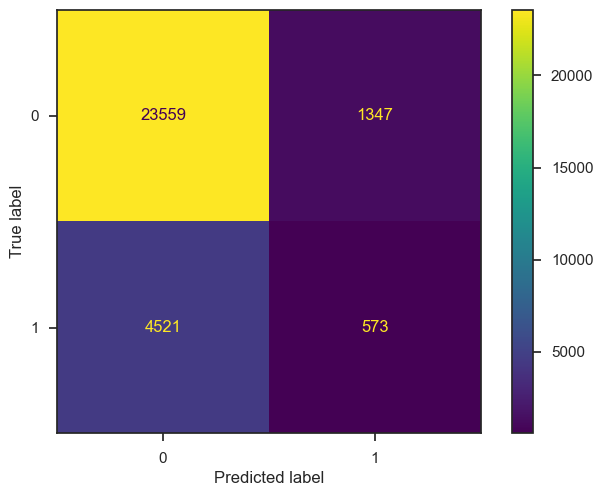

In [618]:
dtree.fit(xtrain1, ytrain1)   # fitting the decision tree model to training data
ypred = dtree.predict(xtest1)       # making prediction from test data
print(metrics.accuracy_score(ytest1, ypred))    # calculating test accuracy for decision tree model
metrics.ConfusionMatrixDisplay.from_predictions(ytest1, ypred)   # visualizing confusion matrix

In [619]:
# calculating roc_auc_score
metrics.roc_auc_score(ytest1, ypred)

0.5292009616937068

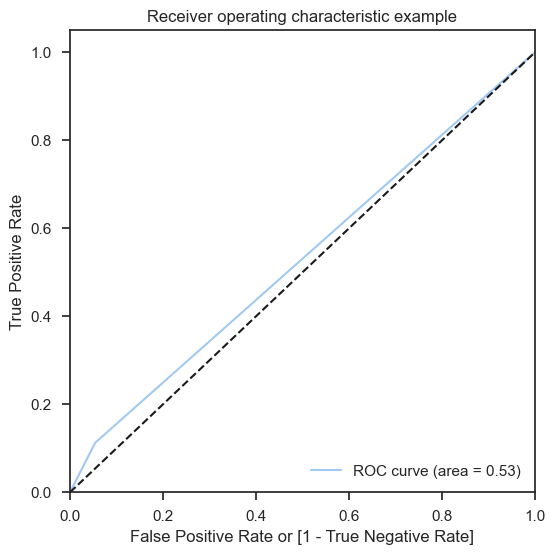

(array([0.        , 0.05408335, 1.        ]),
 array([0.        , 0.11248528, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [620]:
# plotting roc curve for decision tree classifier
draw_roc(ytest1, ypred)

In [621]:
# checking other metrics
print(metrics.classification_report(ytest1, ypred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89     24906
           1       0.30      0.11      0.16      5094

    accuracy                           0.80     30000
   macro avg       0.57      0.53      0.53     30000
weighted avg       0.75      0.80      0.77     30000



In [622]:
# exporting the metrics of decision tree to metrics_results dataframe
metrics_results = pd.concat([metrics_results, results('Basic Decision Tree Model', xtrain1, xtest1, ytrain1, ytest1, dtree, 5)], axis=0)
metrics_results

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,f1_score_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy Classifier,0.830198,0.000000,0.000000,0.830200,0.000000,0.000000,0.000000,0.830198,0.830214,0.830214,0.830214,0.830143,0.830202
0,Basic Logistic Regression,0.957414,0.836446,0.905547,0.812033,0.064782,0.273859,0.104779,0.957528,0.956357,0.958571,0.955357,0.959286,0.958068
0,Logistic Regression with oversampling,0.956920,0.956326,0.957463,0.742010,0.552839,0.889298,0.681819,0.955277,0.924761,0.962702,0.962314,0.963820,0.962788
0,Basic Decision Tree Model,0.969342,0.844355,0.971351,0.804400,0.112485,0.298438,0.163388,0.963585,0.963357,0.964500,0.961857,0.967500,0.960711


With the basic decision tree classifier, the acuracy and other metrics are same as logistic regression models with recall and precision improved a little.

Hyperparameter tuning may help to optimise the decision tree model.

## Hyperparameter tuning of Decision Tree Model

In [623]:
# Create a Parameter grid
param_grid = {'max_depth':range(5,15,5),
                'min_samples_leaf':range(50,150,50),
                'min_samples_split':range(50,150,50),
                'criterion': ['gini', 'entropy'],
                'class_weight': ['balanced', None]}

In [624]:
from sklearn.model_selection import GridSearchCV

In [625]:
dtree = DecisionTreeClassifier()

In [626]:
n_fold = 5

In [627]:
# Creating a Grid with parameters
grid = GridSearchCV(dtree, param_grid, cv=n_fold, n_jobs = -1, return_train_score=True)

In [628]:
grid.fit(xtrain1, ytrain1)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             return_train_score=True)

In [629]:
# getting the best parameters decided by gridsearchcv
grid.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 50,
 'min_samples_split': 50}

In [630]:
# selecting the best estimator as our current model
dtree_best = grid.best_estimator_

In [631]:
# fitting the current best model to traning dataset
dtree_best.fit(xtrain1, ytrain1)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50)

In [632]:
ypred_opt = dtree_best.predict(xtest1)   # predicting using the current model

accuracy 0.8155333333333333


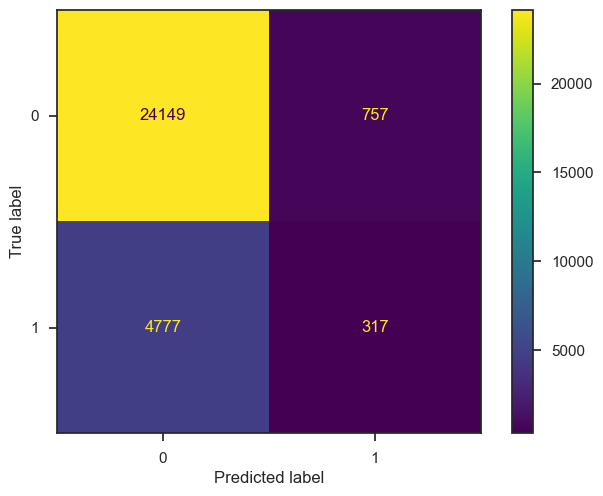

In [633]:
print('accuracy', metrics.accuracy_score(ytest1, ypred_opt))      #calculating the test accuracy from the current model
metrics.ConfusionMatrixDisplay.from_predictions(ytest1, ypred_opt)   # visualizing the confusion matrix

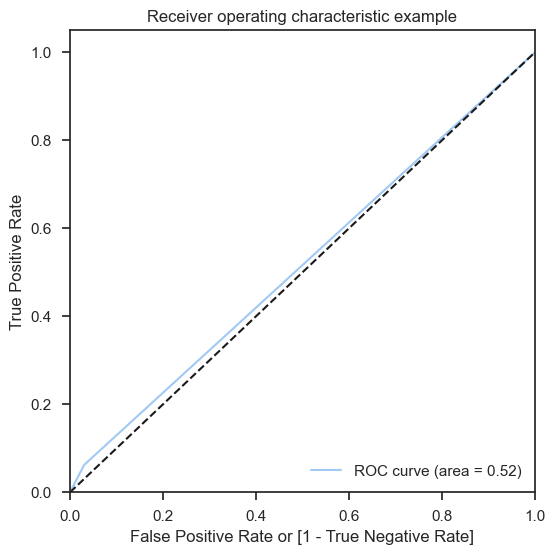

(array([0.        , 0.03039428, 1.        ]),
 array([0.        , 0.06223007, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [634]:
# drawing the roc curve with the current model
draw_roc(ytest1, ypred_opt)

In [635]:
# adding other metrics into the metrics_results dataframe
metrics_results = pd.concat([metrics_results, results('Decision Tree after Hyperparameter Tuning', xtrain1, xtest1, ytrain1, ytest1, dtree_best, 5)], axis=0)
metrics_results

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,f1_score_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy Classifier,0.830198,0.000000,0.000000,0.830200,0.000000,0.000000,0.000000,0.830198,0.830214,0.830214,0.830214,0.830143,0.830202
0,Basic Logistic Regression,0.957414,0.836446,0.905547,0.812033,0.064782,0.273859,0.104779,0.957528,0.956357,0.958571,0.955357,0.959286,0.958068
0,Logistic Regression with oversampling,0.956920,0.956326,0.957463,0.742010,0.552839,0.889298,0.681819,0.955277,0.924761,0.962702,0.962314,0.963820,0.962788
0,Basic Decision Tree Model,0.969342,0.844355,0.971351,0.804400,0.112485,0.298438,0.163388,0.963585,0.963357,0.964500,0.961857,0.967500,0.960711
0,Decision Tree after Hyperparameter Tuning,0.965671,0.828538,0.964261,0.815533,0.062230,0.295158,0.102789,0.964242,0.963143,0.965429,0.961571,0.966714,0.964355


After hyperparameter tuning, the test accuracy remains same and we can see that the model is overfitting the training data and not able to generalize well for the test dataset. we can further improve the model using feature importance, let's look at the random forest models for now.

## Random Forest Classifier

### Basic Random Forest Classifier

In [636]:
from sklearn.ensemble import RandomForestClassifier

In [637]:
# instantiating baseline random forest classifier
rf_basic = RandomForestClassifier()

In [638]:
# fitting the random forest model to traing dataset
rf_basic.fit(xtrain1, ytrain1)

RandomForestClassifier()

0.8147


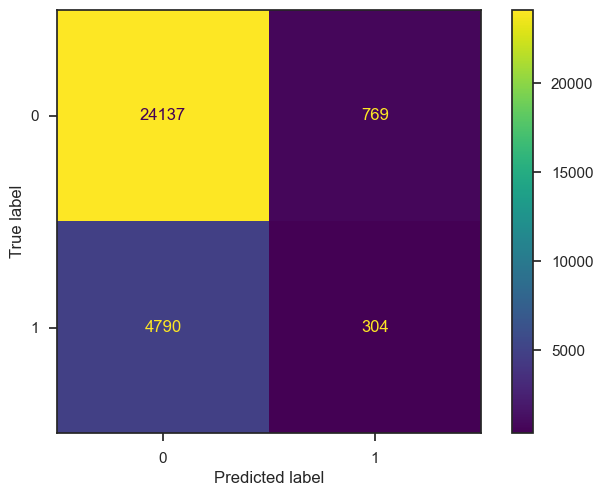

In [639]:
ypred = rf_basic.predict(xtest1)    # making prediction with random forest model
print(metrics.accuracy_score(ytest1, ypred))        # calculating the test accuracy
metrics.ConfusionMatrixDisplay.from_predictions(ytest1, ypred)      # visualizing confusion matrix

In [640]:
# calculating the training accuracy to compare with test accuracy
metrics.accuracy_score(ytrain1, rf_basic.predict(xtrain1))

0.9987142673466763

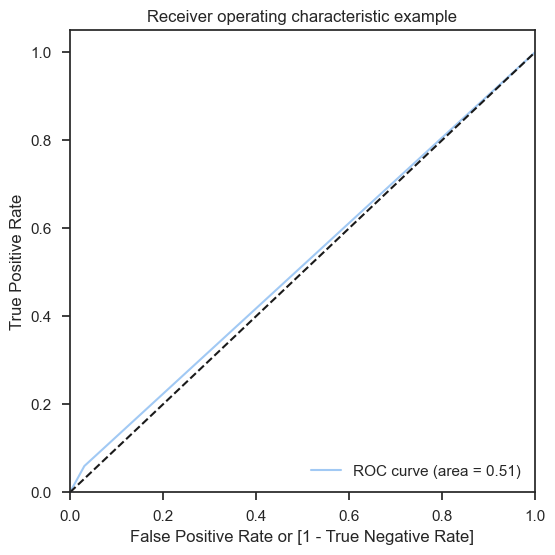

(array([0.        , 0.03087609, 1.        ]),
 array([0.        , 0.05967805, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [641]:
# plotting the roc curve
draw_roc(ytest1, ypred)

In [642]:
# exporting other metrics from random forest model to metrics_result dataframe
metrics_results = pd.concat([metrics_results, results('Basic Random Forest Model', xtrain1, xtest1, ytrain1, ytest1, rf_basic, 5)], axis=0)
metrics_results

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,f1_score_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy Classifier,0.830198,0.000000,0.000000,0.830200,0.000000,0.000000,0.000000,0.830198,0.830214,0.830214,0.830214,0.830143,0.830202
0,Basic Logistic Regression,0.957414,0.836446,0.905547,0.812033,0.064782,0.273859,0.104779,0.957528,0.956357,0.958571,0.955357,0.959286,0.958068
0,Logistic Regression with oversampling,0.956920,0.956326,0.957463,0.742010,0.552839,0.889298,0.681819,0.955277,0.924761,0.962702,0.962314,0.963820,0.962788
0,Basic Decision Tree Model,0.969342,0.844355,0.971351,0.804400,0.112485,0.298438,0.163388,0.963585,0.963357,0.964500,0.961857,0.967500,0.960711
0,Decision Tree after Hyperparameter Tuning,0.965671,0.828538,0.964261,0.815533,0.062230,0.295158,0.102789,0.964242,0.963143,0.965429,0.961571,0.966714,0.964355
0,Basic Random Forest Model,0.998714,0.994363,0.998058,0.814700,0.059678,0.283318,0.098589,0.961414,0.961500,0.960286,0.960214,0.963571,0.961497


Basic random forest model have overfitted the traing dataset, so the training accuracy is very high close to 1.
However, the test accuracy is same as logistic regression and decision tree models and precision and recall also same.

We can improve the model using gridsearchcv and feature importance.

## Hyperparameter Tuning of Random Forest

In [643]:
# Create a Parameter grid
param_grid = {'n_estimators':range(10,101,30),
              'max_depth':  range(5,15,5),
              'criterion': ['gini', 'entropy'],
                'min_samples_leaf':range(50,150,50),
                'min_samples_split':range(50,150,50)}

In [644]:
n_folds = 5

In [645]:
rf = RandomForestClassifier()

In [646]:
# Deciding what metrics to choose while tuning the hyperparameter
scoring = {'Accuracy': 'accuracy', 'Precision': 'precision'}

In [647]:
grid = GridSearchCV(rf, param_grid, cv=n_folds, n_jobs = -1, scoring=scoring, refit='Precision', return_train_score=True)

In [648]:
grid.fit(xtrain1, ytrain1)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50),
                         'n_estimators': range(10, 101, 30)},
             refit='Precision', return_train_score=True,
             scoring={'Accuracy': 'accuracy', 'Precision': 'precision'})

In [649]:
# getting the best parameter as per grid search
grid.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 50,
 'min_samples_split': 50,
 'n_estimators': 70}

In [650]:
# instantiating the best estimator
rff = grid.best_estimator_

In [651]:
# instantiating random forest model after considering the paramters from grid search
rf_tuned = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=100, min_samples_split=50, criterion='gini').fit(xtrain1, ytrain1)

In [652]:
ypred_rf = rf_tuned.predict(xtest1)         # making prediction with tuned random forest classifier
print('training accuracy', metrics.accuracy_score(ytrain1, rf_tuned.predict(xtrain1)))  # calculating training accuracy
print('testing accuracy', metrics.accuracy_score(ytest1, ypred_rf))         # calculating test accuracy

training accuracy 0.9622851755025071
testing accuracy 0.8190666666666667


In [653]:
# checking the precision for current model
metrics.precision_score(ytest1, ypred_rf)

0.2600574712643678

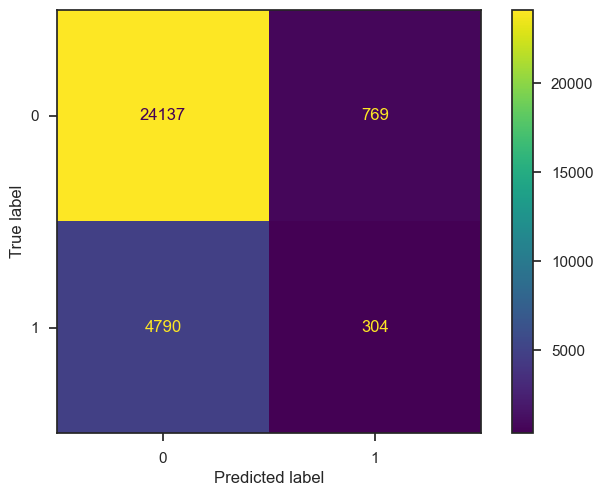

In [654]:
# visualizing confusion matrix for current classifier
metrics.ConfusionMatrixDisplay.from_predictions(ytest1, ypred)

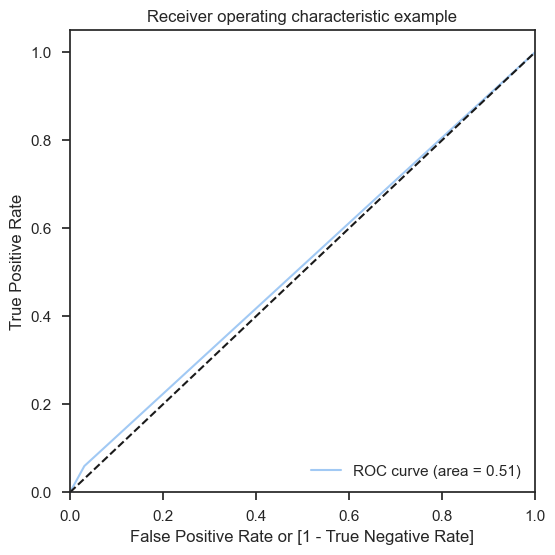

(array([0.        , 0.03087609, 1.        ]),
 array([0.        , 0.05967805, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [655]:
# plotting the roc curve
draw_roc(ytest1, ypred)

In [656]:
# Adding other metrics to metrics_results dataframe to compare wiht other model's metrics
metrics_results = pd.concat([metrics_results, results('Random Forest with hyperparameter Tuning', xtrain1, xtest1, ytrain1, ytest1, rf_tuned, 5)], axis=0)
metrics_results

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,f1_score_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy Classifier,0.830198,0.000000,0.000000,0.830200,0.000000,0.000000,0.000000,0.830198,0.830214,0.830214,0.830214,0.830143,0.830202
0,Basic Logistic Regression,0.957414,0.836446,0.905547,0.812033,0.064782,0.273859,0.104779,0.957528,0.956357,0.958571,0.955357,0.959286,0.958068
0,Logistic Regression with oversampling,0.956920,0.956326,0.957463,0.742010,0.552839,0.889298,0.681819,0.955277,0.924761,0.962702,0.962314,0.963820,0.962788
0,Basic Decision Tree Model,0.969342,0.844355,0.971351,0.804400,0.112485,0.298438,0.163388,0.963585,0.963357,0.964500,0.961857,0.967500,0.960711
0,Decision Tree after Hyperparameter Tuning,0.965671,0.828538,0.964261,0.815533,0.062230,0.295158,0.102789,0.964242,0.963143,0.965429,0.961571,0.966714,0.964355
0,Basic Random Forest Model,0.998714,0.994363,0.998058,0.814700,0.059678,0.283318,0.098589,0.961414,0.961500,0.960286,0.960214,0.963571,0.961497
0,Random Forest with hyperparameter Tuning,0.962285,0.800353,0.972699,0.819067,0.035532,0.260057,0.062522,0.961914,0.961357,0.962571,0.959786,0.964929,0.960926


With the hyperparameter tuning with gridsearchcv the performance of random forest model did not improve significantly.
The model overfits the training dataset and do not perform well with test dataset.

We can try to optimise the performace with feature engineering for all the three classifications performed above

## Building classification models with feature engineering

### Logistic Regression using statsmodel and feature selection using RFE 

In [657]:
# importing necessary libraries
from sklearn.feature_selection import RFE
import statsmodels.api as sm

#### Defining a function to calculate the accuracy score and confusion matrix for statsmodel

In [658]:
# Creating function to evaluate new stats model logistic regression
def sm_model_evaluation (model, x_test, y_test, columns):
    '''
    model = sm model
    y_test = series of labels 
    columns = list of columns in features
    x_test = test dataframe 
    '''
    X_sm = sm.add_constant(x_test[columns])
    y_pred = model.predict(X_sm)
    y_train_pred_final = pd.DataFrame({'y':y_test, 'y_Prob':y_pred})
    y_train_pred_final['predicted'] = y_train_pred_final.y_Prob.map(lambda x: 1 if x > 0.5 else 0)
    # Let's check the overall accuracy.
    print(metrics.accuracy_score(y_train_pred_final.y, y_train_pred_final.predicted))
    confusion = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final.predicted )
    print(confusion)

Splitting data into X and Y for feature engineering

In [659]:
Y = df['y']
X = df.drop('y', axis=1)

In [660]:
# splitting data into traning and test dataset
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(X, Y, stratify=Y, random_state=42)

#### Feature Standardisation

In [661]:
# segregating columns to standardise
Col_standardise = ['C15', 'C16', 'C17', 'C18', 'C19', 'C21', 'dayofweek', 'day', 'hour']

In [662]:
# normalizing the training dataset
x_temp = xtrain2[Col_standardise]
normalized_xtemp = (x_temp-x_temp.mean())/x_temp.std()
xtrain2 = xtrain2.drop(Col_standardise, axis=1)
xtrain2 = pd.concat([xtrain2, normalized_xtemp], axis=1)
xtrain2.head()

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
51404,0,85f751fd,c4e18dd6,50e219e0,f53417e1,0e8616ad,0f2161f8,a99f214a,8f82f685,9ee2ab36,1,2,0.193081,-0.223823,0.905825,-1.085674,-0.548874,1.966936,-0.927497,0.847959,-0.386261
95138,1,85f751fd,c4e18dd6,50e219e0,cf0327f9,2347f47a,0f2161f8,e68e884e,1e491708,24399af1,1,0,-1.751552,-0.223823,0.887745,1.174527,-0.537490,-0.856420,-0.927497,0.847959,1.468801
6434,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,6444e211,c144e605,1,0,0.193081,-0.223823,-0.198713,0.421126,2.379627,-0.713826,1.392375,-0.164363,0.288307
77057,1,85f751fd,c4e18dd6,50e219e0,8c0dcd5a,7801e8d9,0f2161f8,a651d29f,f53791e1,7e8aec57,5,0,0.193081,0.708957,0.655989,1.174527,-0.546028,-0.214748,-0.927497,-1.514124,0.456949
77333,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,6dd11254,36d749e5,1,0,0.193081,-0.223823,0.826930,-1.085674,-0.546028,-0.457157,-0.927497,0.847959,-1.566754


In [663]:
# normalizing the test dataset
x_temp = xtest2[Col_standardise]
normalized_xtemp = (x_temp-x_temp.mean())/x_temp.std()
xtest2 = xtest2.drop(Col_standardise, axis=1)
xtest2 = pd.concat([xtest2, normalized_xtemp], axis=1)
xtest2.head()

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
73024,1,178a7b89,b4598159,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,0c73a50c,5ec45883,1,0,0.193269,-0.223701,0.182309,-1.083865,2.008810,-0.504916,1.992973,0.173695,0.614946
2850,1,85f751fd,c4e18dd6,50e219e0,d644e4e7,2347f47a,0f2161f8,a99f214a,2e02cf68,6d1d04b8,1,0,0.193269,-0.223701,0.369185,1.179657,2.378369,1.075003,1.992973,0.173695,0.782571
43910,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,d9c05222,5db079b5,1,2,0.193269,-0.223701,-2.801088,0.425150,-0.538303,-0.732652,1.411307,-0.161468,-0.223184
75315,0,85f751fd,c4e18dd6,50e219e0,9f41cdad,7801e8d9,07d7df22,32557532,f4424e7a,f9ba9057,0,0,0.193269,-0.223701,0.962887,-1.083865,-0.185801,1.829379,0.247976,1.514345,-1.396565
46349,1,450d6400,bea33b9a,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,5ca07fd4,5096d134,1,0,0.193269,-0.223701,0.873584,1.179657,-0.549674,-0.860754,-0.915356,0.844020,-0.893687


#### Target encoding the data

In [664]:
# fitting the target encoded to training dataset and transforming training and test dataset
xtrain2[encoding_col] = te.fit_transform(xtrain2[encoding_col], ytrain2)
xtest2[encoding_col] = te.transform(xtest2[encoding_col])

In [665]:
# Looking the training dataset after splitting
xtrain2

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
51404,0,0.120393,0.124821,0.130807,0.054755,0.058333,0.104098,0.172776,0.147710,0.081090,1,2,0.193081,-0.223823,0.905825,-1.085674,-0.548874,1.966936,-0.927497,0.847959,-0.386261
95138,1,0.120393,0.124821,0.130807,0.067416,0.142605,0.104098,0.147710,0.147710,0.225137,1,0,-1.751552,-0.223823,0.887745,1.174527,-0.537490,-0.856420,-0.927497,0.847959,1.468801
6434,1,0.279493,0.279318,0.177526,0.197414,0.194183,0.198558,0.172776,0.147710,0.175676,1,0,0.193081,-0.223823,-0.198713,0.421126,2.379627,-0.713826,1.392375,-0.164363,0.288307
77057,1,0.120393,0.124821,0.130807,0.039954,0.194183,0.104098,0.147710,0.147710,0.164032,5,0,0.193081,0.708957,0.655989,1.174527,-0.546028,-0.214748,-0.927497,-1.514124,0.456949
77333,0,0.202828,0.202828,0.205505,0.197414,0.194183,0.198558,0.172776,0.195062,0.216895,1,0,0.193081,-0.223823,0.826930,-1.085674,-0.546028,-0.457157,-0.927497,0.847959,-1.566754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37978,0,0.120393,0.124821,0.130807,0.335966,0.142605,0.272134,0.172776,0.147710,0.242065,1,0,0.193081,-0.223823,0.143168,1.174527,-0.546028,-0.571232,-0.927497,-1.514124,-1.060828
56957,0,0.427461,0.463136,0.285048,0.197414,0.194183,0.198558,0.172776,0.145716,0.289973,1,0,-1.751552,4.440076,-0.197070,0.421126,-0.534644,-0.713826,-0.347529,1.185399,0.456949
53013,0,0.120393,0.124821,0.130807,0.191539,0.191450,0.104098,0.172776,0.147710,0.090604,1,0,0.193081,-0.223823,-0.016267,1.174527,4.565330,1.253967,0.232439,1.522839,-1.566754
76830,0,0.743417,0.124821,0.130807,0.197414,0.194183,0.198558,0.724277,0.277818,0.435110,0,0,0.193081,-0.223823,0.937055,0.421126,3.130962,-0.442898,0.232439,1.522839,1.637443


#### Running RFE on baseline logistic regression

In [666]:
# Instantiating baseline logistic regression and fitting to training dataset
model = LogisticRegression()
model.fit(xtrain2, ytrain2)

LogisticRegression()

In [667]:
xtrain2.shape

(74999, 21)

##### Running RFE on loop on number of features to decide the optimum number of features

In [668]:
for i in range(10, 21):
    rfe = RFE(model, n_features_to_select=i)           # running RFE with i variable output.
    rfe = rfe.fit(xtrain2, ytrain2)
    col = xtrain2.columns[rfe.support_]
    xtrain_sm = sm.add_constant(xtrain2[col])
    logm2 = sm.GLM(ytrain2,xtrain_sm, family = sm.families.Binomial())
    res = logm2.fit()
    print ("=====================================================")
    print (i)
    sm_model_evaluation (res, xtest2, ytest2, col)

10
0.81016
[[19964   791]
 [ 3955   290]]
11
0.80996
[[19961   794]
 [ 3957   288]]
12
0.8104
[[19965   790]
 [ 3950   295]]
13
0.81072
[[19973   782]
 [ 3950   295]]
14
0.81072
[[19975   780]
 [ 3952   293]]
15
0.81068
[[19972   783]
 [ 3950   295]]
16
0.81048
[[19967   788]
 [ 3950   295]]
17
0.81024
[[19962   793]
 [ 3951   294]]
18
0.81012
[[19960   795]
 [ 3952   293]]
19
0.81012
[[19959   796]
 [ 3951   294]]
20
0.81012
[[19960   795]
 [ 3952   293]]


Conclusion: 

If we keep 15 features it appears that there is a slight improvement in performance which stays the same even if we increase the maximum features till 21. 

Let's find columns we need to keep. 

Running RFE on 15 features and getting the features to keep

In [669]:
rfe = RFE(model, n_features_to_select= 15)           # running RFE with 26 variable output.
rfe = rfe.fit(xtrain2, ytrain2)
col = xtrain2.columns[rfe.support_]
X_train_sm = sm.add_constant(xtrain2[col])
logm2 = sm.GLM(ytrain2,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
sm_model_evaluation (res, xtest2, ytest2, col)

0.81068
[[19972   783]
 [ 3950   295]]


In [670]:
# columns selected from RFE
col

Index(['banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id',
       'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model',
       'device_type', 'device_conn_type', 'C19', 'C21', 'hour'],
      dtype='object')

In [671]:
# Create correlation matrix
corr_matrix = xtrain2[col].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [672]:
# visualising
upper.style.background_gradient(cmap ='viridis')

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C19,C21,hour
banner_pos,nan,0.056010,0.066408,0.096867,0.142976,0.266022,0.203319,0.013804,0.011014,0.035132,0.320410,0.087405,0.130078,0.097150,0.008319
site_id,nan,nan,0.926906,0.461321,0.205289,0.251252,0.307085,0.163789,0.285818,0.279597,0.097927,0.156201,0.084417,0.146755,0.033630
site_domain,nan,nan,nan,0.475958,0.197897,0.242205,0.296027,0.025443,0.234679,0.204766,0.060866,0.151526,0.057494,0.146788,0.035590
site_category,nan,nan,nan,nan,0.333187,0.407785,0.498403,0.010118,0.127696,0.224105,0.025239,0.241566,0.070874,0.065503,0.002917
app_id,nan,nan,nan,nan,nan,0.746976,0.697692,0.098113,0.198760,0.438938,0.204334,0.456077,0.022139,0.086967,0.021183
app_domain,nan,nan,nan,nan,nan,nan,0.581848,0.035484,0.145723,0.482828,0.014893,0.443623,0.038150,0.046706,0.049959
app_category,nan,nan,nan,nan,nan,nan,nan,0.070538,0.126938,0.330697,0.243567,0.358758,0.035745,0.056040,0.016190
device_id,nan,nan,nan,nan,nan,nan,nan,nan,0.296766,0.137679,0.116440,0.045205,0.052233,0.025147,0.008933
device_ip,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.250592,0.036251,0.083704,0.046856,0.048936,0.007998
device_model,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.137093,0.341696,0.021022,0.041728,0.028969


#### Checking VIFs

In [673]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

Creating VIF dataframe to stoer vif of each features

In [674]:
vif = pd.DataFrame()
vif['Features'] = xtrain2[col].columns
vif['VIF'] = [variance_inflation_factor(xtrain2[col].values, i) for i in range(xtrain2[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,app_domain,37.55
2,site_domain,34.33
6,app_category,32.62
1,site_id,31.94
4,app_id,27.36
7,device_id,26.86
3,site_category,22.73
8,device_ip,16.05
9,device_model,10.89
10,device_type,6.06


All the features do not have very high VIF
So, we can keep these many columns for model

Let's evaluate the model on other metrics

In [675]:
X_sm = sm.add_constant(xtest2[col])
y_pred = res.predict(X_sm)
y_train_pred_final = pd.DataFrame({'y':ytest2, 'y_Prob':y_pred})
y_train_pred_final['predicted'] = y_train_pred_final.y_Prob.map(lambda x: 1 if x > 0.5 else 0)
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.y, y_train_pred_final.predicted))
confusion = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final.predicted )
print(confusion)

0.81068
[[19972   783]
 [ 3950   295]]


In [676]:
# checking the recall score
metrics.recall_score(y_train_pred_final.y, y_train_pred_final.predicted)

0.06949352179034157

In [677]:
# checking the precision score
metrics.precision_score(y_train_pred_final.y, y_train_pred_final.predicted)

0.27365491651205937

#### Finding optimal cutoff point to tune recall and precision

In [678]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/20 for x in range(20)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.y_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,y,y_Prob,predicted,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
73024,0,0.151500,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2850,0,0.046191,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43910,0,0.043406,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
75315,0,0.027995,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
46349,0,0.064819,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [679]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['Thresold_prob','accuracy','recall','precision'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final[i])
    recall = metrics.recall_score(y_train_pred_final.y, y_train_pred_final[i])
    precision = metrics.precision_score(y_train_pred_final.y, y_train_pred_final[i])
    accuracy = metrics.accuracy_score(y_train_pred_final.y, y_train_pred_final[i])
    cutoff_df.loc[i] =[ i ,accuracy,recall,precision]
cutoff_df

,Thresold_prob,accuracy,recall,precision
0.00,0.00,0.16980,1.000000,0.169800
0.05,0.05,0.72484,0.391755,0.279027
0.10,0.10,0.77952,0.217197,0.296368
0.15,0.15,0.78740,0.158304,0.278376
0.20,0.20,0.79236,0.116372,0.255429
0.25,0.25,0.79720,0.102002,0.256062
0.30,0.30,0.80012,0.089517,0.251323
0.35,0.35,0.80292,0.083628,0.255029
0.40,0.40,0.80512,0.077739,0.256410
0.45,0.45,0.80796,0.073263,0.264007


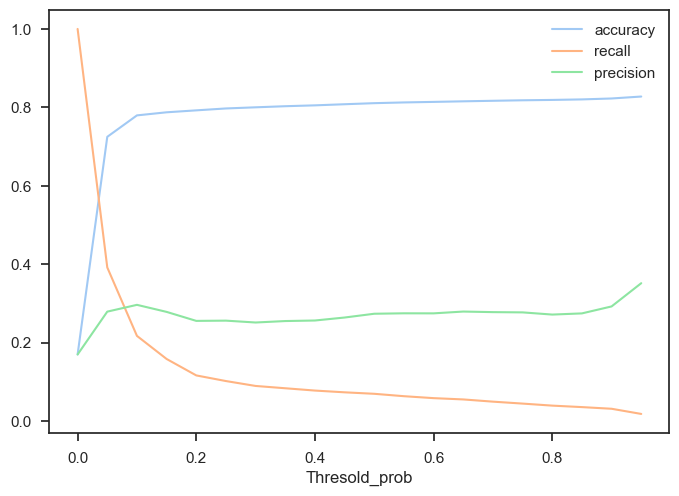

In [680]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='Thresold_prob', y=['accuracy','recall','precision'])
plt.show()

From the curve above, 0.1 is the optimum point to take it as a cutoff probability.

In [681]:
# predicting with 0.1 cutoff for test dataset
y_train_pred_final['final_predicted'] = y_train_pred_final.y_Prob.map( lambda x: 1 if x > 0.1 else 0)
y_train_pred_final.head()

,y,y_Prob,predicted,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,final_predicted
73024,0,0.151500,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2850,0,0.046191,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43910,0,0.043406,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
75315,0,0.027995,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
46349,0,0.064819,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [682]:
# Let's check the overall accuracy after altering the threshold
metrics.accuracy_score(y_train_pred_final.y, y_train_pred_final.final_predicted)

0.77952

In [683]:
# Let's check the precision after altering the threshold
metrics.precision_score(y_train_pred_final.y, y_train_pred_final.final_predicted)

0.2963677274188364

In [684]:
# Let's check the recall after altering the threshold
metrics.recall_score(y_train_pred_final.y, y_train_pred_final.final_predicted)

0.21719670200235572

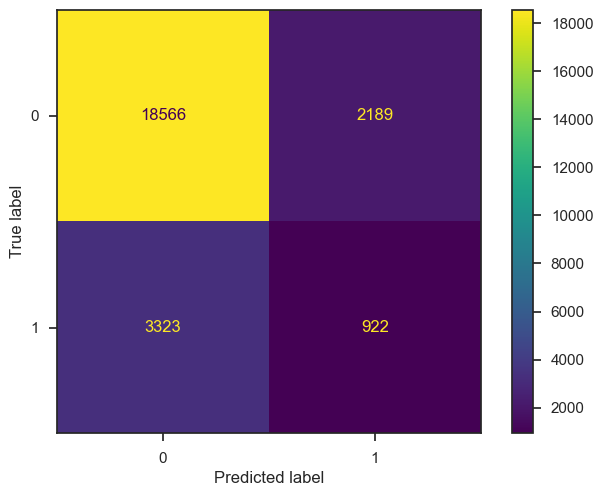

In [685]:
# visualizing the confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_train_pred_final.y, y_train_pred_final.final_predicted)

In [686]:
# predicting for train dataset to compare the metrics for test dataset
X_sm = sm.add_constant(xtrain2[col])
y_pred = res.predict(X_sm)
y_train_pred = pd.DataFrame({'y':ytrain2, 'ytrain_Prob':y_pred})
y_train_pred['train_predicted'] = y_train_pred.ytrain_Prob.map(lambda x: 1 if x > 0.1 else 0)

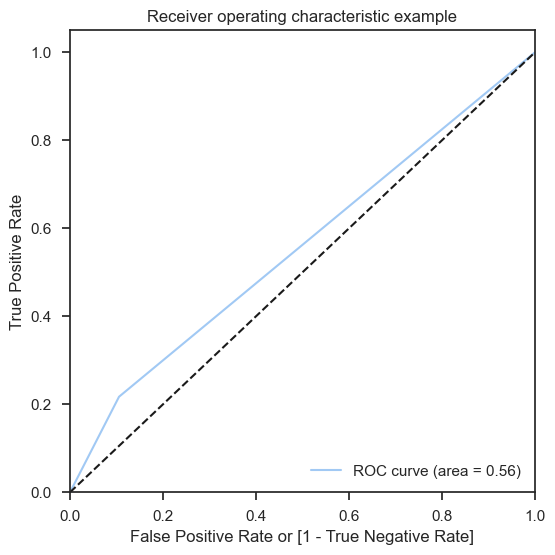

(array([0.        , 0.10546856, 1.        ]),
 array([0.       , 0.2171967, 1.       ]),
 array([2, 1, 0], dtype=int64))

In [687]:
# plotting the roc curve with new model
draw_roc(y_train_pred_final.y, y_train_pred_final.final_predicted)

Checking other metrics and appending to the metrics results dataframe

In [688]:
crossvalidation = cross_val_score(model, xtrain2, ytrain2, cv= 5)

test_accuracy = metrics.accuracy_score(y_train_pred_final.y, y_train_pred_final.final_predicted)
test_recall = metrics.recall_score(y_train_pred_final.y, y_train_pred_final.final_predicted)
test_precision = metrics.precision_score(y_train_pred_final.y, y_train_pred_final.final_predicted)


train_accuracy = metrics.accuracy_score(y_train_pred.y, y_train_pred.train_predicted)
train_recall = metrics.recall_score(y_train_pred.y, y_train_pred.train_predicted)
train_precision = metrics.precision_score(y_train_pred.y, y_train_pred.train_predicted)
f1_score = metrics.f1_score(y_train_pred.y, y_train_pred.train_predicted)
roc_auc_score = metrics.roc_auc_score(y_train_pred.y, y_train_pred.train_predicted)

entry = {'Model': ['Logistic Regression with Feature Engineering'],
        'Accuracy_train': [train_accuracy],
        'recall_train': [train_recall],
        'precision_train': [train_precision],
        'Accuracy_test': [test_accuracy],
        'recall_test': [test_recall],
        'precision_test': [test_precision],
        'f1_score_test': [f1_score],
        'CrossVal_Mean': [crossvalidation.mean()],           
        'CrossVal1': [crossvalidation[0]],
        'CrossVal2': [crossvalidation[1]],
        'CrossVal3': [crossvalidation[2]],
        'CrossVal4': [crossvalidation[3]],
        'CrossVal5': [crossvalidation[4]],
        }
result = pd.DataFrame(entry)

In [689]:
metrics_results = pd.concat([metrics_results, result], axis=0)
metrics_results

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,f1_score_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy Classifier,0.830198,0.000000,0.000000,0.830200,0.000000,0.000000,0.000000,0.830198,0.830214,0.830214,0.830214,0.830143,0.830202
0,Basic Logistic Regression,0.957414,0.836446,0.905547,0.812033,0.064782,0.273859,0.104779,0.957528,0.956357,0.958571,0.955357,0.959286,0.958068
0,Logistic Regression with oversampling,0.956920,0.956326,0.957463,0.742010,0.552839,0.889298,0.681819,0.955277,0.924761,0.962702,0.962314,0.963820,0.962788
0,Basic Decision Tree Model,0.969342,0.844355,0.971351,0.804400,0.112485,0.298438,0.163388,0.963585,0.963357,0.964500,0.961857,0.967500,0.960711
0,Decision Tree after Hyperparameter Tuning,0.965671,0.828538,0.964261,0.815533,0.062230,0.295158,0.102789,0.964242,0.963143,0.965429,0.961571,0.966714,0.964355
0,Basic Random Forest Model,0.998714,0.994363,0.998058,0.814700,0.059678,0.283318,0.098589,0.961414,0.961500,0.960286,0.960214,0.963571,0.961497
0,Random Forest with hyperparameter Tuning,0.962285,0.800353,0.972699,0.819067,0.035532,0.260057,0.062522,0.961914,0.961357,0.962571,0.959786,0.964929,0.960926
0,Logistic Regression with Feature Engineering,0.935666,0.955634,0.740718,0.779520,0.217197,0.296368,0.834562,0.956693,0.957333,0.957133,0.953667,0.957800,0.957531


With Feature engineering, we have reduced the number of features used significantly in the model as well as the threshold for prediction.
with the selected features and threshold, we have balanced recall and precision for the model with same accuracy as before.

### Decision Tree with Feature Importance

In [690]:
# instantiating Decision Tree model as per the hyperparameter after grid search
dtree2 = DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50)

In [691]:
# Fitting to the training set
dtree2.fit(xtrain1, ytrain1)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50)

Getting the feature importance of each features and storing a dataframe

In [692]:
feature_importances = dtree2.feature_importances_
features = xtrain1.columns
imp_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})
imp_df.sort_values(by='Importance', ascending = False)

,Features,Importance
8,device_ip,0.964870
7,device_id,0.018465
2,site_domain,0.006800
9,device_model,0.004766
1,site_id,0.001987
16,C19,0.000990
20,hour,0.000902
19,day,0.000358
17,C21,0.000291
14,C17,0.000280


Decision tree is giving .96 importance to only one feature 'device_ip' and other features were not given much importance.

Removing the features with 0 feature importance according to decision tree

In [693]:
imp_df = imp_df[round(imp_df.Importance, 4) != 0]
cols = []
for col in list(xtrain1.columns):
    if col in list(imp_df.Features):
        cols.append(col)

In [694]:
# Features after removing zero imoprtance features
cols

['site_id',
 'site_domain',
 'device_id',
 'device_ip',
 'device_model',
 'C17',
 'C18',
 'C19',
 'C21',
 'dayofweek',
 'day',
 'hour']

Fitting the decision tree with only the columns selected

In [695]:
dtree_fe = DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50)

In [696]:
# Fitting the model to the selected features
dtree_fe.fit(xtrain1[cols], ytrain1)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50)

In [697]:
# predicting with the selected features
ypred_dt_fe = dtree_fe.predict(xtest1[cols])

0.8155333333333333


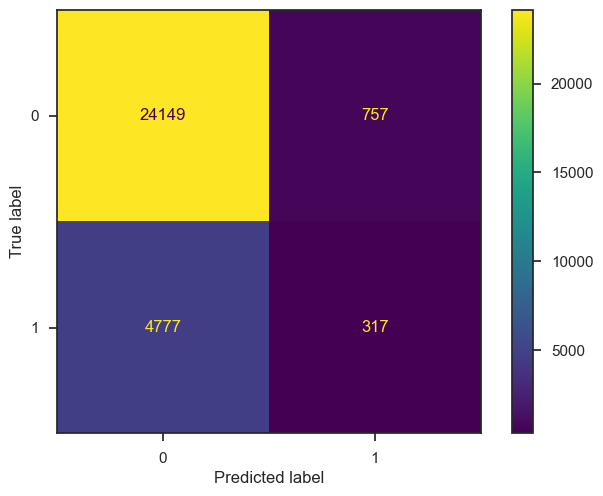

In [698]:
print(metrics.accuracy_score(ytest1, ypred_dt_fe))      # calculating the accuracy for new fitted model
metrics.ConfusionMatrixDisplay.from_predictions(ytest1, ypred_dt_fe)    # visualizing the confusion matrix

In [699]:
# adding other metrics into the metrics_results dataframe
metrics_results = pd.concat([metrics_results, results('Decision Tree with feature engineering', xtrain1[cols], xtest1[cols], ytrain1, ytest1, dtree_fe, 5)], axis=0)
metrics_results

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,f1_score_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy Classifier,0.830198,0.000000,0.000000,0.830200,0.000000,0.000000,0.000000,0.830198,0.830214,0.830214,0.830214,0.830143,0.830202
0,Basic Logistic Regression,0.957414,0.836446,0.905547,0.812033,0.064782,0.273859,0.104779,0.957528,0.956357,0.958571,0.955357,0.959286,0.958068
0,Logistic Regression with oversampling,0.956920,0.956326,0.957463,0.742010,0.552839,0.889298,0.681819,0.955277,0.924761,0.962702,0.962314,0.963820,0.962788
0,Basic Decision Tree Model,0.969342,0.844355,0.971351,0.804400,0.112485,0.298438,0.163388,0.963585,0.963357,0.964500,0.961857,0.967500,0.960711
0,Decision Tree after Hyperparameter Tuning,0.965671,0.828538,0.964261,0.815533,0.062230,0.295158,0.102789,0.964242,0.963143,0.965429,0.961571,0.966714,0.964355
0,Basic Random Forest Model,0.998714,0.994363,0.998058,0.814700,0.059678,0.283318,0.098589,0.961414,0.961500,0.960286,0.960214,0.963571,0.961497
0,Random Forest with hyperparameter Tuning,0.962285,0.800353,0.972699,0.819067,0.035532,0.260057,0.062522,0.961914,0.961357,0.962571,0.959786,0.964929,0.960926
0,Logistic Regression with Feature Engineering,0.935666,0.955634,0.740718,0.779520,0.217197,0.296368,0.834562,0.956693,0.957333,0.957133,0.953667,0.957800,0.957531
0,Decision Tree with feature engineering,0.965671,0.828538,0.964261,0.815533,0.062230,0.295158,0.102789,0.964342,0.963143,0.965857,0.961643,0.966714,0.964355


In [700]:
feature_importances = dtree_fe.feature_importances_
features = cols
imp_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})
imp_df.sort_values(by='Importance', ascending = False)

,Features,Importance
3,device_ip,0.964877
2,device_id,0.018465
1,site_domain,0.006800
4,device_model,0.004769
0,site_id,0.001985
7,C19,0.000990
11,hour,0.000903
10,day,0.000362
8,C21,0.000291
5,C17,0.000277


With the Decision Tree classifier after selecting features based on feature importance, it gives a good test accuracy but it also overfits the dataset. Also, this model gives 96% of importance to only one feature and may be dependent on only one feature which would cause the model to not generalize well
Hence, we can't use this model and look for random forest feature engineering

### Random Forest with Feature Engineering

In [701]:
# instantiating random forest classifier with parameters after grid search
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=100, min_samples_split=50, criterion='gini')

In [702]:
# fitting on the training dataset
rf_model.fit(xtrain1, ytrain1)

RandomForestClassifier(max_depth=5, min_samples_leaf=100, min_samples_split=50)

getting the feature importance as per random forest classifier and storing in a dataframe

In [703]:
feature_importances = rf_model.feature_importances_
features = xtrain1.columns
imp_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})
imp_df.sort_values(by='Importance', ascending = False)

,Features,Importance
8,device_ip,0.692320
7,device_id,0.143848
1,site_id,0.055841
2,site_domain,0.025346
4,app_id,0.021895
9,device_model,0.018510
13,C16,0.013387
3,site_category,0.005640
12,C15,0.005265
6,app_category,0.005166


Selecting features with feature importance less than 0.005

In [704]:
imp_df = imp_df[round(imp_df.Importance, 3) >= 0.005]
rf_cols = []
for col in list(xtrain1.columns):
    if col in list(imp_df.Features):
        rf_cols.append(col)

In [705]:
# checking the features selected after removing the less important features
rf_cols

['site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_category',
 'device_id',
 'device_ip',
 'device_model',
 'C15',
 'C16']

Fitting the random forest classifier with only selected columns

In [706]:
rf_model_fe = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=100, min_samples_split=50, criterion='gini').fit(xtrain1[rf_cols], ytrain1)

0.8191666666666667


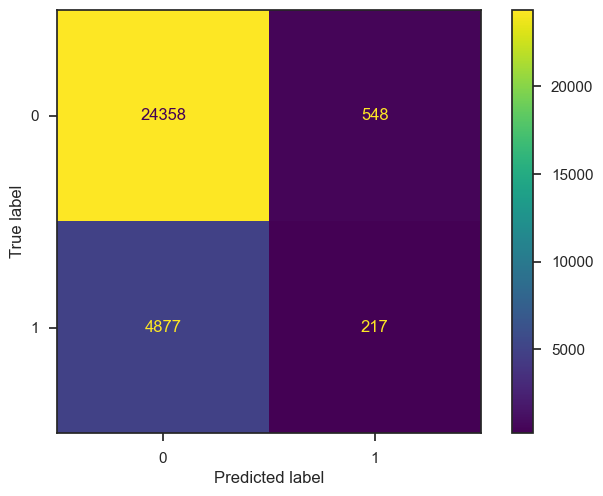

In [707]:
ypred_rf = rf_model_fe.predict(xtest1[rf_cols])     # making prediction with new random forest model
print(metrics.accuracy_score(ytest1, ypred_rf))     # calculating accuracy with new random forest model
metrics.ConfusionMatrixDisplay.from_predictions(ytest1, ypred_rf)   # visualizing confusion matrix

In [708]:
# adding other metrics into the metrics_results dataframe
metrics_results = pd.concat([metrics_results, results('Random Forest Classifier with feature engineering', xtrain1[rf_cols], xtest1[rf_cols], ytrain1, ytest1, rf_model_fe, 5)], axis=0)
metrics_results

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,f1_score_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy Classifier,0.830198,0.000000,0.000000,0.830200,0.000000,0.000000,0.000000,0.830198,0.830214,0.830214,0.830214,0.830143,0.830202
0,Basic Logistic Regression,0.957414,0.836446,0.905547,0.812033,0.064782,0.273859,0.104779,0.957528,0.956357,0.958571,0.955357,0.959286,0.958068
0,Logistic Regression with oversampling,0.956920,0.956326,0.957463,0.742010,0.552839,0.889298,0.681819,0.955277,0.924761,0.962702,0.962314,0.963820,0.962788
0,Basic Decision Tree Model,0.969342,0.844355,0.971351,0.804400,0.112485,0.298438,0.163388,0.963585,0.963357,0.964500,0.961857,0.967500,0.960711
0,Decision Tree after Hyperparameter Tuning,0.965671,0.828538,0.964261,0.815533,0.062230,0.295158,0.102789,0.964242,0.963143,0.965429,0.961571,0.966714,0.964355
0,Basic Random Forest Model,0.998714,0.994363,0.998058,0.814700,0.059678,0.283318,0.098589,0.961414,0.961500,0.960286,0.960214,0.963571,0.961497
0,Random Forest with hyperparameter Tuning,0.962285,0.800353,0.972699,0.819067,0.035532,0.260057,0.062522,0.961914,0.961357,0.962571,0.959786,0.964929,0.960926
0,Logistic Regression with Feature Engineering,0.935666,0.955634,0.740718,0.779520,0.217197,0.296368,0.834562,0.956693,0.957333,0.957133,0.953667,0.957800,0.957531
0,Decision Tree with feature engineering,0.965671,0.828538,0.964261,0.815533,0.062230,0.295158,0.102789,0.964342,0.963143,0.965857,0.961643,0.966714,0.964355
0,Random Forest Classifier with feature engineering,0.962671,0.810113,0.964347,0.819167,0.042599,0.283660,0.074074,0.962499,0.962143,0.962929,0.960143,0.965000,0.962283


In [709]:
feature_importances = rf_model_fe.feature_importances_
features = rf_cols
imp_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})
imp_df.sort_values(by='Importance', ascending = False)

,Features,Importance
6,device_ip,0.790050
5,device_id,0.111088
0,site_id,0.040795
1,site_domain,0.024042
7,device_model,0.013545
3,app_id,0.011515
2,site_category,0.003694
9,C16,0.003197
4,app_category,0.001180
8,C15,0.000892


With the random forest classifier after selecting features based on feature importance, it gives a good test accuracy but it also overfits the dataset. Also, this model gives 83% of importance to only one feature and may be dependent on only one feature which would cause the model to not generalize well

Observations:
- Decision Tree and Random Forest classifiers overfits the data with hyperparameter tuning and even after removing less important features and are not able to generalize well with test dataset
- On the other hand logistic regression model with feature engineering after selecting features which maximizes the TP and TN and minimizes FP and FN. Also, we selected an optimum threshold which gave better recall and precision value compared to other model, keeping the accuracy very optimal

In [711]:
metrics_results.to_csv('metrics_results.csv')

## Interpreting Logistic Regression Classifier after Feature Engineering

In [712]:
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                74999
Model:                            GLM   Df Residuals:                    74983
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8631.4
Date:                Tue, 16 May 2023   Deviance:                       17263.
Time:                        22:03:56   Pearson chi2:                 4.74e+05
No. Iterations:                     8   Pseudo R-squ. (CS):             0.4939
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -19.7836      0.321  

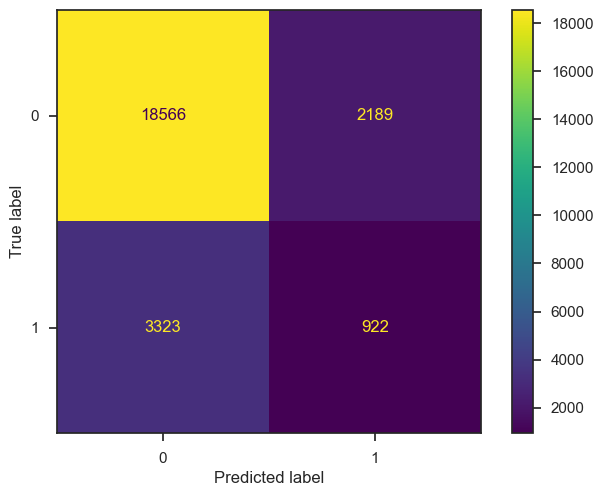

In [713]:
metrics.ConfusionMatrixDisplay.from_predictions(y_train_pred_final.y, y_train_pred_final.final_predicted)

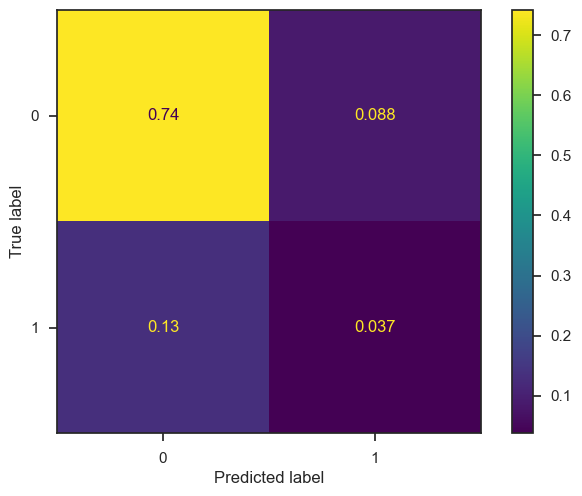

In [714]:
metrics.ConfusionMatrixDisplay.from_predictions(y_train_pred_final.y, y_train_pred_final.final_predicted, normalize='all')

## Conclusion

- Logistic Regression with feature engineering giving best result and precision-recall tradeoff, we can use this model to predict and intrepret the results of click through rate.
- With the summary, we can interpret that device_type, device_conn_type and C21 are not significant features. Since, C21 is anonymized feature, we can say about other two features that device type or device connection type do not contribute to the click through rate
- Features such as 'device_ip', 'device_id', 'site_domain', 'device_id', 'site_domain', 'app_id' and 'site_category' contributes positively to the click through rate.